**DOMAIN**: Health Care

**CONTEXT**:
Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation
of the lungs. In this challenge, you’re required to build an algorithm to detect a visual signal for pneumonia in medical
images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

**DATA DESCRIPTION**:
- In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was
determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the
appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data.
- Dataset has been attached along with this project. Please use the same for this capstone project.
- Original link to the dataset : https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data [ for your reference
only ]. You can refer to the details of the dataset in the above link
- Acknowledgements: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements.

**PROJECT OBJECTIVE**: Design a DL based algorithm for detecting pneumonia.


**Milestone 1**

**importing important libs**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import keras
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import pickle


import csv
import random
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Reshape, Concatenate, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input,GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models


!pip install pydicom
import pydicom as dcm
from pydicom.pixel_data_handlers.util import apply_voi_lut

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Milestone 1**

**Step 1: Import the data. [ 3 points ]**

In [ ]:
train_labels = pd.read_csv("drive/My Drive/cv capstone/stage_2_train_labels.csv") 
print(train_labels.shape)
print(train_labels.head())
detailed_class_info = pd.read_csv("drive/My Drive/cv capstone/stage_2_detailed_class_info.csv")
print(detailed_class_info.shape)
print(detailed_class_info.head())

(30227, 6)
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
(30227, 2)
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


In [ ]:
detailed_class_info.isna().sum()
len(detailed_class_info['patientId'].unique())

26684

In [ ]:
train_labels.isna().sum()
len(train_labels['patientId'].unique())

26684

In [ ]:
print('Total number of null values in bounding boxes columns(x, y, width, height): {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Total value counts for the Target column: {}'.format(train_labels['Target'].value_counts().to_dict()))

Total number of null values in bounding boxes columns(x, y, width, height): {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Total value counts for the Target column: {0: 20672, 1: 9555}


**Observation:** Total number of null values in bounding boxes columns is equal to total number of 0s in Target column.

In [ ]:
#Analysing the labels dataframe
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
#Checking for unique patient records ==total number of patients
train_labels.patientId.nunique()

26684

In [ ]:
train_labels["patientId"].count()-train_labels.patientId.nunique()

3543

**Observation:** From the above data, we can notice that there are around 30227 rows in stage_2_train_labels.csv but we have a total of 26684 unique patientIDs. Hence 3543 patients have more than one bounding box. Verifying this for a patient with the patientId: 00436515-870c-4b36-a041-de91049b9ab4 is the same from 4th and 5th rows of the dataframe.

In [ ]:
train_labels[train_labels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

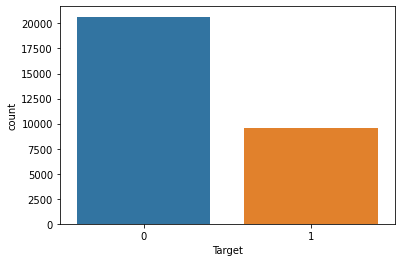

In [ ]:
sns.countplot(x='Target',data=train_labels);

In [ ]:
detailed_class_info.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

**Observation:** There are 3 different class values - Normal,Lung Opacity and No Lung Opacity/Not Normal.

In [ ]:
detailed_class_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
detailed_class_info.describe()

patientId                         class
count                                  30227                         30227
unique                                 26684                             3
top     3239951b-6211-4290-b237-3d9ad17176db  No Lung Opacity / Not Normal
freq                                       4                         11821

In [ ]:
#Checking for duplicate values
detailed_class_info[detailed_class_info.duplicated()].shape

(3543, 2)

**Observation:** The total number of patients match with the value from training labels which is 26684. 

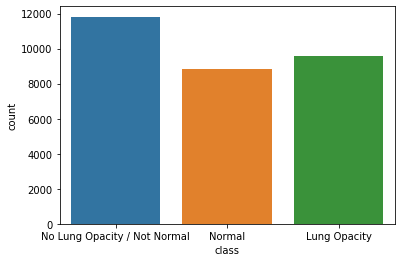

In [ ]:
#Checking the class values distribution
sns.countplot(x='class',data=detailed_class_info);

**Observation:**  From the countplot, it is very much noticeable that all the classes are almost equally distributed. We can further check for duplicate and missing values as well

In [ ]:
#Checking for missing values
detailed_class_info.isnull().sum()

patientId    0
class        0
dtype: int64

**Observation:** There are no missing values in the class info data

**Step 2: Map training and testing images to its classes. [ 4 points ]**

In [ ]:
# Conctinating the two dataset - 'train_labels' and 'detailed_class_info':
train = pd.concat([train_labels,detailed_class_info['class']], axis = 1)

train.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [ ]:
print(train.isna().sum())
print(len(train['patientId'].unique()))

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64
26684


In [ ]:
print(train[train['Target'] == 0].isna().sum())

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64


In [ ]:
print(train[train['class'] == 'Normal'].isna().sum())
print(train[train['class'] == 'No Lung Opacity / Not Normal'].isna().sum())
print(train[train['class'] == 'Lung Opacity'].isna().sum())

patientId       0
x            8851
y            8851
width        8851
height       8851
Target          0
class           0
dtype: int64
patientId        0
x            11821
y            11821
width        11821
height       11821
Target           0
class            0
dtype: int64
patientId    0
x            0
y            0
width        0
height       0
Target       0
class        0
dtype: int64


In [ ]:
train[['x', 'y', 'width', 'height']].isnull().sum().to_dict()

{'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}

**Observation:** Total number of null values for "Normal" and "No Lung Opacity / Not Normal" is equal to total number of 0s in Target column i.e., who do not have pnemonia have their bounding box columns as NaN

**Step 3: Map training and testing images to its annotations [ 4 points ]**

In [ ]:
dcm_image_data = dcm.read_file('drive/My Drive/cv capstone/stage_2_train_images/c1edf42b-5958-47ff-a1e7-4f23d99583ba.dcm')
print(dcm_image_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.22672.1517874443.53337
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.22672.1517874443.53337
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

**Observation**
1.   Images are stored in DICOM(Digital Imaging and Communications in Medicine) format with .dcm extension. This DICOM image contains more information like patient age, sex, modality, view position and body part and so on. 
2.   pydicom library is used to rread images



In [ ]:
dcm_image_data  = dcm.dcmread('drive/My Drive/cv capstone/stage_2_train_images/c1edf42b-5958-47ff-a1e7-4f23d99583ba.dcm').pixel_array
dcm_image_data .shape

(1024, 1024)

**Observation:** Dimension of images are 1024x1024. It is very large to process so we will reduce it during model training.

In [ ]:
columns = ['Modality', 'Age', 'Sex']
train_path = os.listdir('drive/My Drive/cv capstone/stage_2_train_images/')
class_metadata = train
for col in columns:
    class_metadata[col] = None
for index,file_name in enumerate(train_path):
    print('processing:',index,file_name)
    image_data = dcm.read_file('drive/My Drive/cv capstone/stage_2_train_images/'+file_name)
    patient_id = (class_metadata['patientId']==image_data.PatientID)
    class_metadata.loc[patient_id,'Modality'] = image_data.Modality
    class_metadata.loc[patient_id,'PatientAge'] = pd.to_numeric(image_data.PatientAge)
    class_metadata.loc[patient_id,'PatientSex'] = image_data.PatientSex
    class_metadata.loc[patient_id,'ViewPosition'] = image_data.ViewPosition
    class_metadata.loc[patient_id,'BodyPartExamined'] = image_data.BodyPartExamined

Streaming output truncated to the last 5000 lines.
processing: 5118 cd38e7eb-c6fd-46cd-ad22-7c88d2813204.dcm
processing: 5119 cd0ae273-2dc6-4093-975c-b33e8982e441.dcm
processing: 5120 cd4077d1-5a23-4938-a7df-22c9e2f36299.dcm
processing: 5121 cc455bfc-0efb-418e-a45d-c42723afd6b8.dcm
processing: 5122 ccd2d3ca-cd9e-4ed1-a4ea-e3989c590e4d.dcm
processing: 5123 cd320bb4-874c-43eb-b0ad-edcf6cb89c75.dcm
processing: 5124 cc956272-fef3-4c1e-b950-8e1d05d52d37.dcm
processing: 5125 ccd24f2e-dfe9-4a26-9c84-0caa0b67cbdc.dcm
processing: 5126 cc9a9148-7419-4ba6-a56d-a7acdaae2d4d.dcm
processing: 5127 cd337666-342b-4f0f-b1b2-1fbdcbac2c7e.dcm
processing: 5128 cce6a7b4-893f-4988-a0d1-49a50145818f.dcm
processing: 5129 cd1b5928-d462-4b44-a6c6-c85558b4b6ea.dcm
processing: 5130 cc972377-e6b1-4325-82b9-131e5235c5c9.dcm
processing: 5131 cd60ad78-1b2f-48f6-bdaa-6bf401d8ce2f.dcm
processing: 5132 cca1fb30-2635-4b30-b868-ff9f936e4531.dcm
processing: 5133 cc2fa386-47c5-4e79-bb6a-3f7d15c2d149.dcm
processing: 5134 ccfb

In [ ]:
class_metadata.BodyPartExamined.value_counts()

In [ ]:
class_metadata.Modality.value_counts()

**Observation:**


*   "BodyPartExamined" is CHEST which is expected
*   "Modality" is CR (Computer Radiography)

In [ ]:
class_metadata.drop(['Age', 'Sex', 'BodyPartExamined'], axis=1,inplace =True)
class_metadata.head()

In [ ]:
picklefile = open('drive/My Drive/cv capstone/train1', 'wb')
pickle.dump(class_metadata, picklefile)
picklefile.close()

In [ ]:
picklefile = open('drive/My Drive/cv capstone/train1', 'rb')
training_data= pickle.load(picklefile)
picklefile.close()

In [ ]:
 #Converting age to Numeric as the current data type is a String
training_data['PatientAge'] = training_data.PatientAge.astype(int)

In [ ]:
filepaths=[]
source_dir='drive/My Drive/cv capstone/stage_2_train_images/'


In [ ]:
for f in training_data['patientId']:
    fpath=os.path.join(source_dir,f)
    filepaths.append(fpath)

In [ ]:
training_data['path']=filepaths

In [ ]:
training_data.sample(5)

patientId      x      y  width  height  \
29886  28b55977-46e6-4113-a582-e93ba5c25cd6    NaN    NaN    NaN     NaN   
19959  b8043f6e-400d-4bf3-8f4b-4a708c41ffba    NaN    NaN    NaN     NaN   
28178  f9a3c734-1483-4385-ab4f-e45853f3f00e  682.0  445.0  195.0   173.0   
27240  f218fda3-c484-4836-867d-b7ad037bfe4e  239.0  426.0  155.0   166.0   
14460  8eee2836-b938-4953-b394-99facc3f78e1  162.0  430.0  240.0   395.0   

       Target         class Modality  PatientAge PatientSex ViewPosition  \
29886       0        Normal       CR          25          M           PA   
19959       0        Normal       CR          55          M           PA   
28178       1  Lung Opacity       CR          77          M           AP   
27240       1  Lung Opacity       CR          10          F           AP   
14460       1  Lung Opacity       CR          36          M           AP   

                                                    path  
29886  drive/My Drive/cv capstone/stage_2_train_image...  
19959  drive/My Drive/cv capstone/stage_2_train_image...  
28178  drive/My Drive/cv capstone/stage_2_train_image...  
27240  drive/My Drive/cv capstone/stage_2_train_image...  
14460  drive/My Drive/cv capstone/stage_2_train_image...

In [ ]:
import matplotlib.patches as patches
def MapImagesToAnnotations(pid): # mapping images and annotations
  data = list(training_data[training_data['patientId']==pid].T.to_dict().values())
  for i,dr in enumerate(data):
    patientImage =dr['patientId']
    target=dr['Target']
    cls =dr['class']   
    f, ax = plt.subplots()
    id =dr['path']+'.dcm'
    pic = dcm.read_file(id, force =True)
    modality = pic.Modality
    age = pic.PatientAge
    sex = pic.PatientSex
    bodyPart = pic.BodyPartExamined
    img= pic.pixel_array
    ax.imshow(img,cmap=plt.cm.bone)
    ax.set_title('ID: {} \nModality: {} Age: {} Sex: {} class: {} Target: {} BodyPartExamined: {}'.format(pid,modality,age,sex,cls,target,bodyPart))
    if dr['Target']==1:
      x, y, width, height  =  dr['x'],dr['y'],dr['width'],dr['height']
      rect = patches.Rectangle((x, y),width, height,color="blue",alpha = 0.2)
      ax.add_patch(rect)
  plt.show()


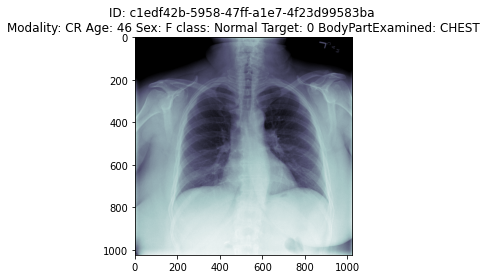

In [ ]:
MapImagesToAnnotations('c1edf42b-5958-47ff-a1e7-4f23d99583ba') #mapping image and annotations 

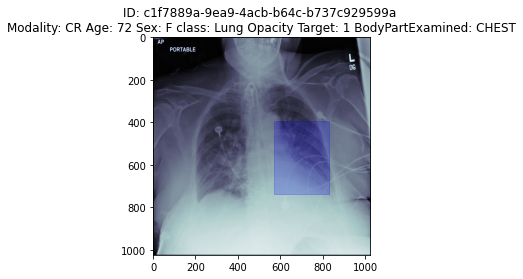

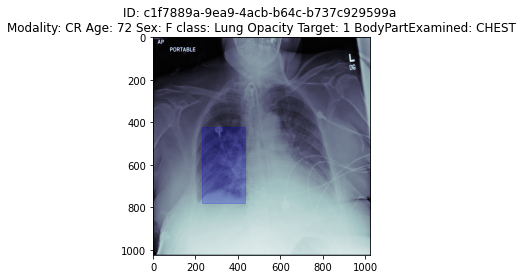

In [ ]:
MapImagesToAnnotations('c1f7889a-9ea9-4acb-b64c-b737c929599a') #mapping image and annotations

**Step 4:Preprocessing and Visualisation of different classes [4 Points]**

In [ ]:
training_data.describe(include="all").T

count unique  \
patientId       30227  26684   
x              9555.0    NaN   
y              9555.0    NaN   
width          9555.0    NaN   
height         9555.0    NaN   
Target        30227.0    NaN   
class           30227      3   
Modality        30227      1   
PatientAge    30227.0    NaN   
PatientSex      30227      2   
ViewPosition    30227      2   
path            30227  26684   

                                                            top   freq  \
patientId                  3239951b-6211-4290-b237-3d9ad17176db      4   
x                                                           NaN    NaN   
y                                                           NaN    NaN   
width                                                       NaN    NaN   
height                                                      NaN    NaN   
Target                                                      NaN    NaN   
class                              No Lung Opacity / Not Normal  11821   
Modality                                                     CR  30227   
PatientAge                                                  NaN    NaN   
PatientSex                                                    M  17216   
ViewPosition                                                 AP  15297   
path          drive/My Drive/cv capstone/stage_2_train_image...      4   

                    mean         std   min    25%    50%    75%    max  
patientId            NaN         NaN   NaN    NaN    NaN    NaN    NaN  
x             394.047724  204.574172   2.0  207.0  324.0  594.0  835.0  
y              366.83956  148.940488   2.0  249.0  365.0  478.5  881.0  
width         218.471376   59.289475  40.0  177.0  217.0  259.0  528.0  
height        329.269702  157.750755  45.0  203.0  298.0  438.0  942.0  
Target          0.316108    0.464963   0.0    0.0    0.0    1.0    1.0  
class                NaN         NaN   NaN    NaN    NaN    NaN    NaN  
Modality             NaN         NaN   NaN    NaN    NaN    NaN    NaN  
PatientAge     46.797764    16.89294   1.0   34.0   49.0   59.0  155.0  
PatientSex           NaN         NaN   NaN    NaN    NaN    NaN    NaN  
ViewPosition         NaN         NaN   NaN    NaN    NaN    NaN    NaN  
path                 NaN         NaN   NaN    NaN    NaN    NaN    NaN

**Observation:** The mean age is 46 years , where as minimum age is 1 year and the max age is 155 which seems to be an outlier

 50% of the patiens are of aroudn 49 age , the std deviation is 16 which sugges that age is not normally distubuted

In [ ]:
training_data.PatientSex.value_counts()

M    17216
F    13011
Name: PatientSex, dtype: int64

Text(0.5, 1.0, 'class and Target for Chest Exams')

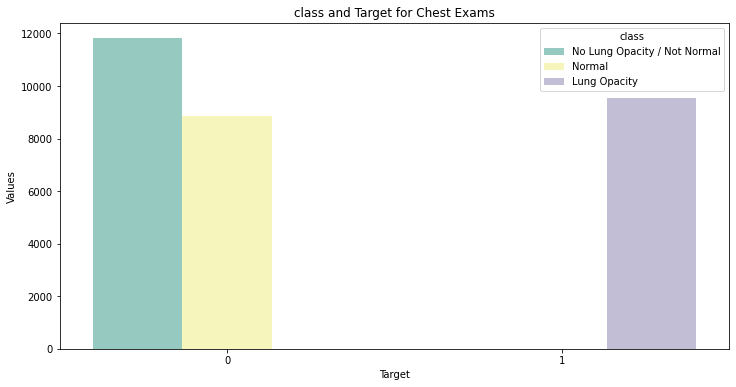

In [ ]:
## Distbution of Class Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('class and Target for Chest Exams')

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

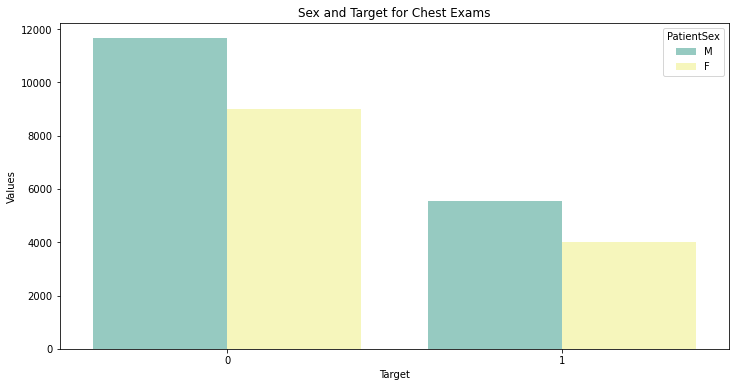

In [ ]:
## Distbution of Sex Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['PatientSex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'PatientSex', data = data_target_class, palette = 'Set3')
plt.title('Sex and Target for Chest Exams')

**Observation:** The number of males in both category are higher than women 

Text(0.5, 1.0, 'Sex and class for Chest Exams')

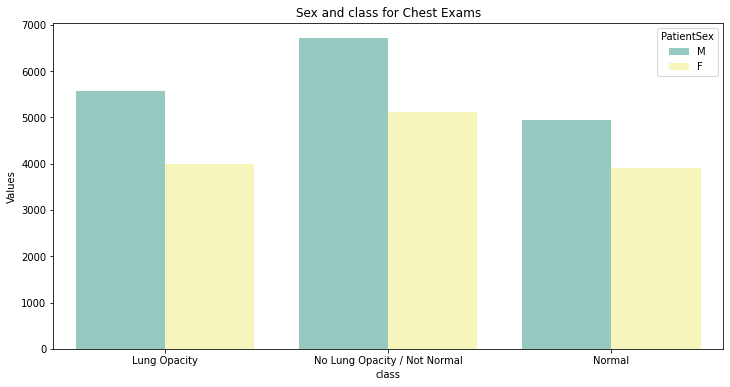

In [ ]:
## Distbution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['PatientSex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'PatientSex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

**Observation:**  The number of males in all classes are higher than women

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


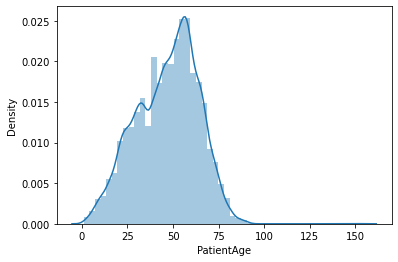

In [ ]:
# plots the distrubution of age
sns.distplot(training_data.PatientAge) 

**Observation:**  Looks like normal distubution of age

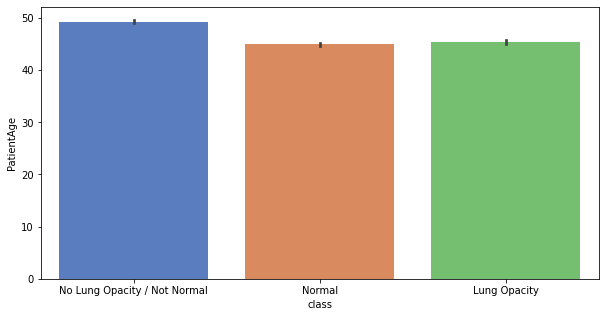

In [ ]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='PatientAge', data=training_data, palette='muted')  # barplot'

**Observation:** This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

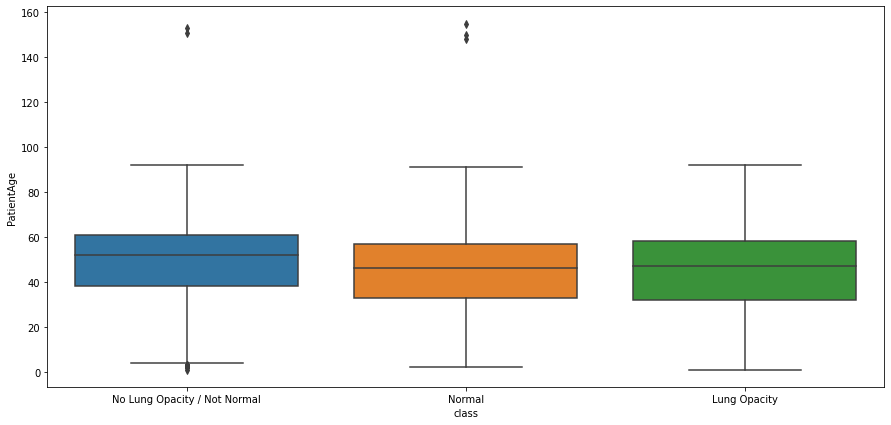

In [ ]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='PatientAge', data= training_data)
plt.show()

**Observation:** The  class which has no pneuomia has few outliers , theie age is somewhere around 155 years so we can clip the upper threshold to 100

In [ ]:
training_data['PatientAge'] = training_data['PatientAge'].clip(training_data['PatientAge'].min(), 100)

In [ ]:
temp = training_data
print('Number of patients in age category ')
temp['CategoryAge'] = pd.cut(temp['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
temp['CategoryAge'].value_counts()

Number of patients in age category 


<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: CategoryAge, dtype: int64

In [ ]:
label_count=temp['CategoryAge'].value_counts()
explode = (0.01,0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('CategoryAge Distribution Overall')
plt.show()

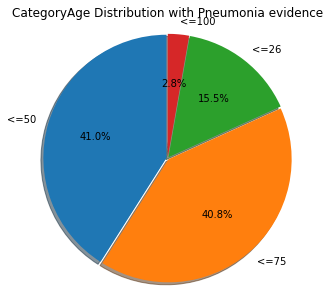

In [ ]:
label_count=temp.loc[temp['Target'] == 1,'CategoryAge'].value_counts()
explode = (0.01,0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('CategoryAge Distribution with Pneumonia evidence')
plt.show()

**Observation:**   

1.   Number of patients are highest for age group 51-75 for overall case
2.   But number of patients are highest for age group 27-50 for Target=1 case.

In [ ]:
training_data['class'].value_counts()


No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

**Observation:** 
*   There are 8851 normal cases , person with lung opactiry are 9555 and No Lung Opacity / Not Normal are 11821 
* Patients with evidence of Pneumonia are associated with Lung Opacity class and target = 1.
* Patients with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class and target = 0.

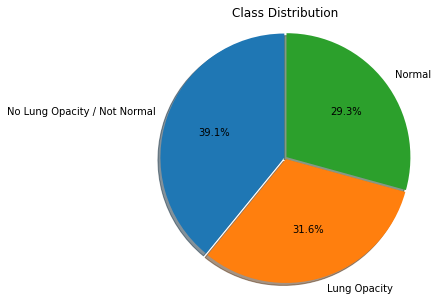

In [ ]:
label_count=training_data['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

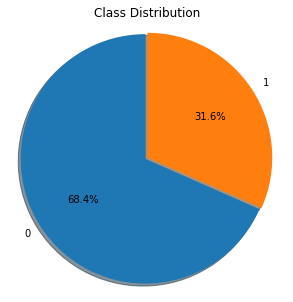

In [ ]:
label_count=training_data['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

* **Posterior/Anterior (PA)**: X-ray is taken from back part of chest. So it hits posterior part before anterior part. Patient needs to stand against X-ray machine.
* **Anterior/Posterior (AP)**: X-ray is taken from front part of chest. So it hits anterior part before posterior part. When Patient cannot stand against X-ray machine. this is taken but heart size is exaggerated.

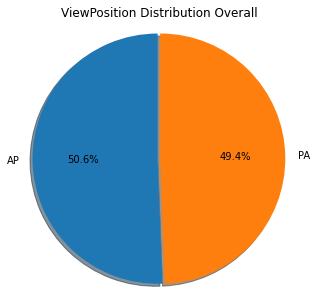

In [ ]:
label_count=training_data['ViewPosition'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('ViewPosition Distribution Overall')
plt.show()

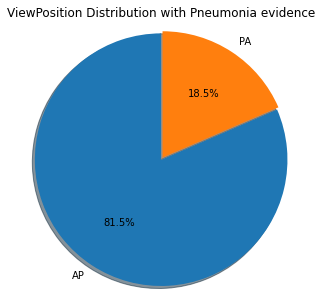

In [ ]:
label_count=training_data.loc[training_data['Target'] == 1,'ViewPosition'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('ViewPosition Distribution with Pneumonia evidence')
plt.show()

**Observation:** 
1.   ViewPosition = PA and ViewPosition = AP are almost equally distributed in the overall train data
2.   When Target=1, View position = AP dominates.

Text(0.5, 1.0, 'View Positon and Target for Chest Exams')

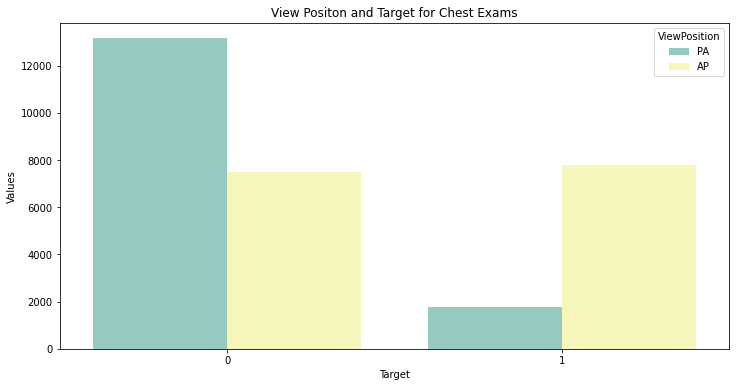

In [ ]:
# Distbution of Viewposition Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['ViewPosition'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'ViewPosition', data = data_target_class, palette = 'Set3')
plt.title('View Positon and Target for Chest Exams')

Text(0.5, 1.0, 'View Positon and class for Chest Exams')

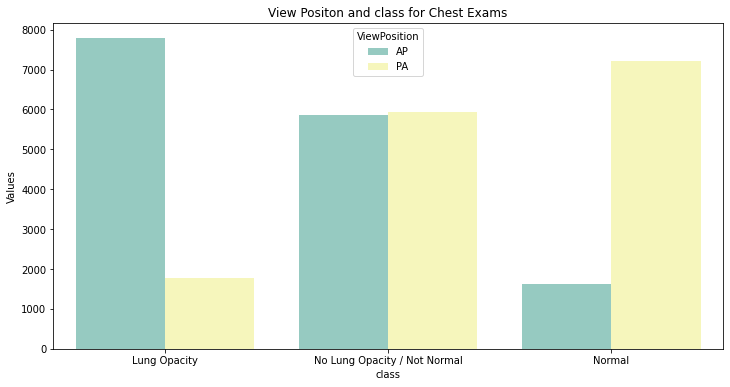

In [ ]:
# Distbution of Viewposition Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['ViewPosition'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'ViewPosition', data = data_target_class, palette = 'Set3')
plt.title('View Positon and class for Chest Exams')

In [ ]:
from matplotlib.patches import Rectangle

def plot_diagram(train_data, pnemonia_point_color, chest_image_color,text):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    plt.title("Pneumonia presence points on the chest image\n{}".format(text))
    train_data.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color=pnemonia_point_color)
    for i, train_row in train_data.iterrows():
        ax.add_patch(Rectangle(xy=(train_row['x'], train_row['y']),
            width=train_row['width'],height=train_row['height'],alpha=3.5e-3, color=chest_image_color))
    plt.show()

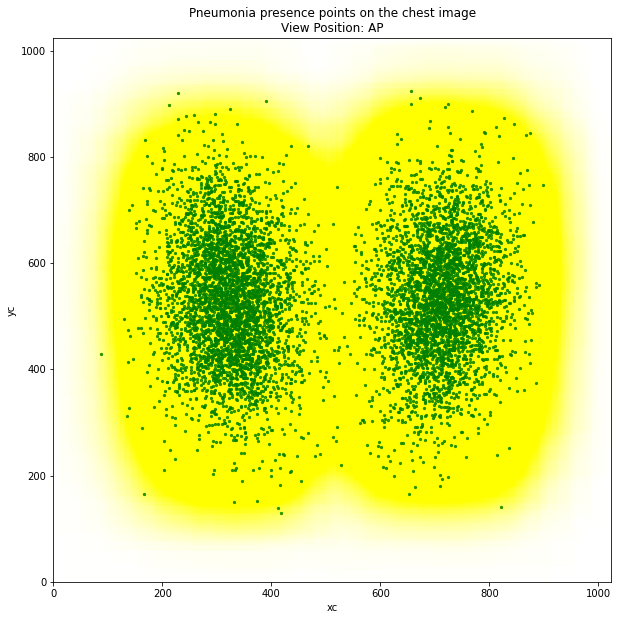

In [ ]:
temp = training_data
temp['xc'] = temp['x'] + temp['width'] / 2
temp['yc'] = temp['y'] + temp['height'] / 2
rows = (temp['ViewPosition']=='AP')  & (temp['Target']==1)
plot_diagram(temp[ rows ],'green', 'yellow', 'View Position: AP')

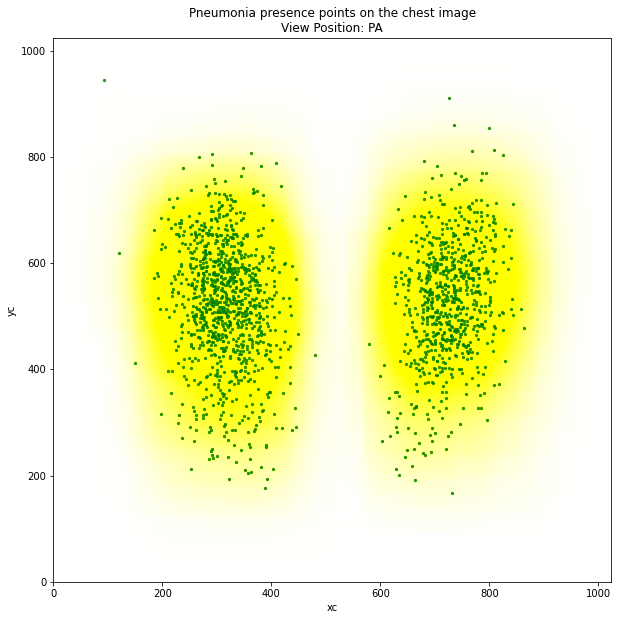

In [ ]:
rows = (temp['ViewPosition']=='PA')  & (temp['Target']==1)
plot_diagram(temp[ rows ],'green', 'yellow', 'View Position: PA')

In [ ]:
training_data.drop(['xc', 'yc','CategoryAge'], axis=1,inplace =True) #dropping unecessary columns now

In [ ]:
bounding_boxes = training_data[training_data['Target'] == 1]
bounding_boxes = bounding_boxes.groupby('patientId').size().to_frame('number_of_bounding_boxes').reset_index()
train_labels = training_data.merge(bounding_boxes, on = 'patientId', how = 'left')
print('Number of patients per bounding boxes in the dataset')
(bounding_boxes.groupby('number_of_bounding_boxes').size().to_frame('number_of_patients_per_bounding_boxes').reset_index().set_index('number_of_bounding_boxes').sort_values(by = 'number_of_bounding_boxes'))

Number of patients per bounding boxes in the dataset


number_of_patients_per_bounding_boxes
number_of_bounding_boxes                                       
1                                                          2614
2                                                          3266
3                                                           119
4                                                            13

In [ ]:
train_labels.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class Modality  PatientAge PatientSex ViewPosition  \
0  No Lung Opacity / Not Normal       CR          51          F           PA   
1  No Lung Opacity / Not Normal       CR          48          F           PA   
2  No Lung Opacity / Not Normal       CR          19          M           AP   
3                        Normal       CR          28          M           PA   
4                  Lung Opacity       CR          32          F           AP   

                                                path  number_of_bounding_boxes  
0  drive/My Drive/cv capstone/stage_2_train_image...                       NaN  
1  drive/My Drive/cv capstone/stage_2_train_image...                       NaN  
2  drive/My Drive/cv capstone/stage_2_train_image...                       NaN  
3  drive/My Drive/cv capstone/stage_2_train_image...                       NaN  
4  drive/My Drive/cv capstone/stage_2_train_image...                       2.0

In [ ]:
train_labels[train_labels['patientId'] == '00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target  \
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   

          class Modality  PatientAge PatientSex ViewPosition  \
4  Lung Opacity       CR          32          F           AP   
5  Lung Opacity       CR          32          F           AP   

                                                path  number_of_bounding_boxes  
4  drive/My Drive/cv capstone/stage_2_train_image...                       2.0  
5  drive/My Drive/cv capstone/stage_2_train_image...                       2.0

**Observations**: Maximum patients have 2 bounding boxes while 13 patients have 4 bounding boxes.

Disturbution of Classes, there are 39% of patients with No Lung opacity , 29.3% Normal



 **Step 5: Display images with bounding box. [ 5 points ]**

In [ ]:
from matplotlib.patches import Rectangle
def boundbox(data):
  image_data = list(data.T.to_dict().values())
  f, axes = plt.subplots(2,2, figsize=(16,18))
  for index, patient_info in enumerate(image_data):
      lungs_image = patient_info['patientId']+'.dcm'
      lungs_image_data = dcm.read_file('drive/My Drive/cv capstone/stage_2_train_images/'+lungs_image)
      axes[index//2, index%2].imshow(lungs_image_data.pixel_array, cmap=plt.cm.gray) 
      axes[index//2, index%2].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                  patient_info['patientId'],lungs_image_data.Modality, lungs_image_data.PatientAge, lungs_image_data.PatientSex, patient_info['Target'], patient_info['class']))
      matched_rows = training_data[training_data['patientId']==patient_info['patientId']]
      bounding_box = list(matched_rows.T.to_dict().values())
      for j, row in enumerate(bounding_box):
          axes[index//2, index%2].add_patch(Rectangle(xy=(row['x'], row['y']),width=row['width'],height=row['height'], color="blue",alpha = 0.1))   
  plt.show()

**X-ray images with ONE bounding box**

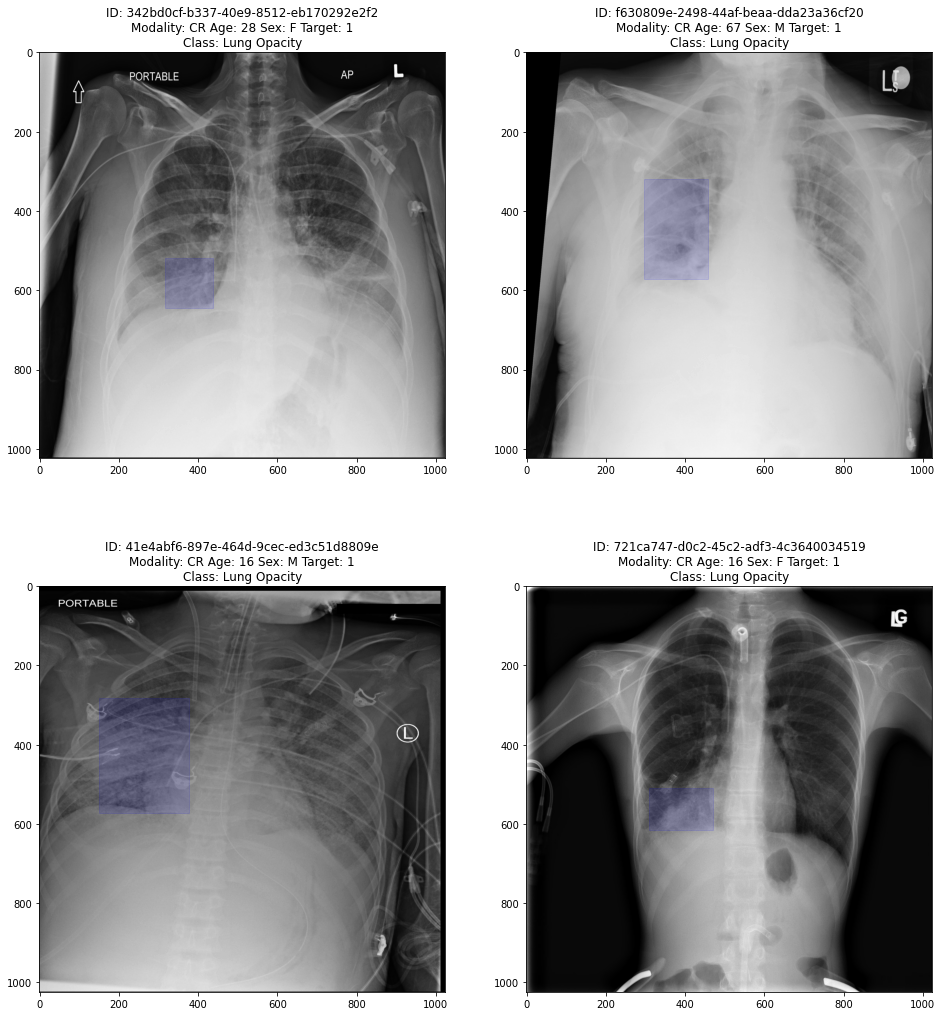

In [ ]:
data = train_labels[train_labels['number_of_bounding_boxes']==1].sample(4) 
boundbox(data)

**X-ray images with TWO bounding box**

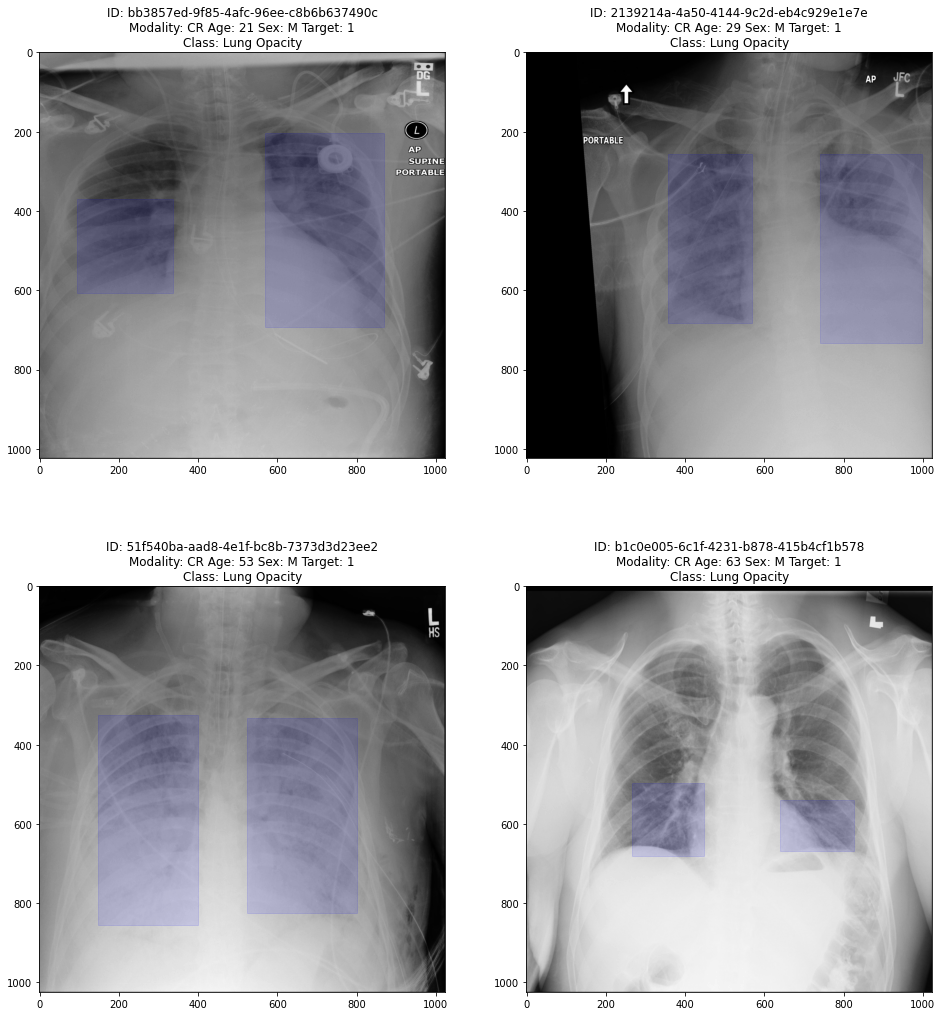

In [ ]:
data = train_labels[train_labels['number_of_bounding_boxes']==2].sample(4) 
boundbox(data)

**X-ray images with THREE bounding box**

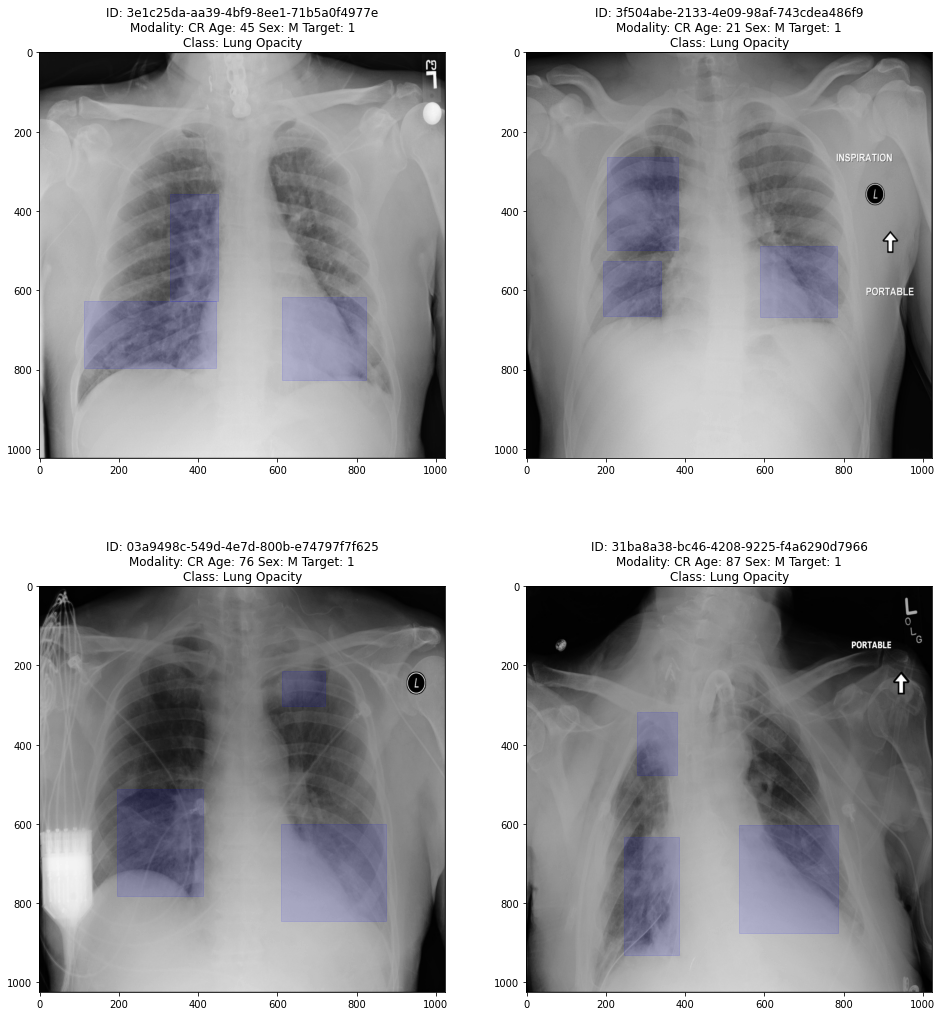

In [ ]:
data = train_labels[train_labels['number_of_bounding_boxes']==3].sample(4) 
boundbox(data)

**X-ray images with FOUR bounding box**

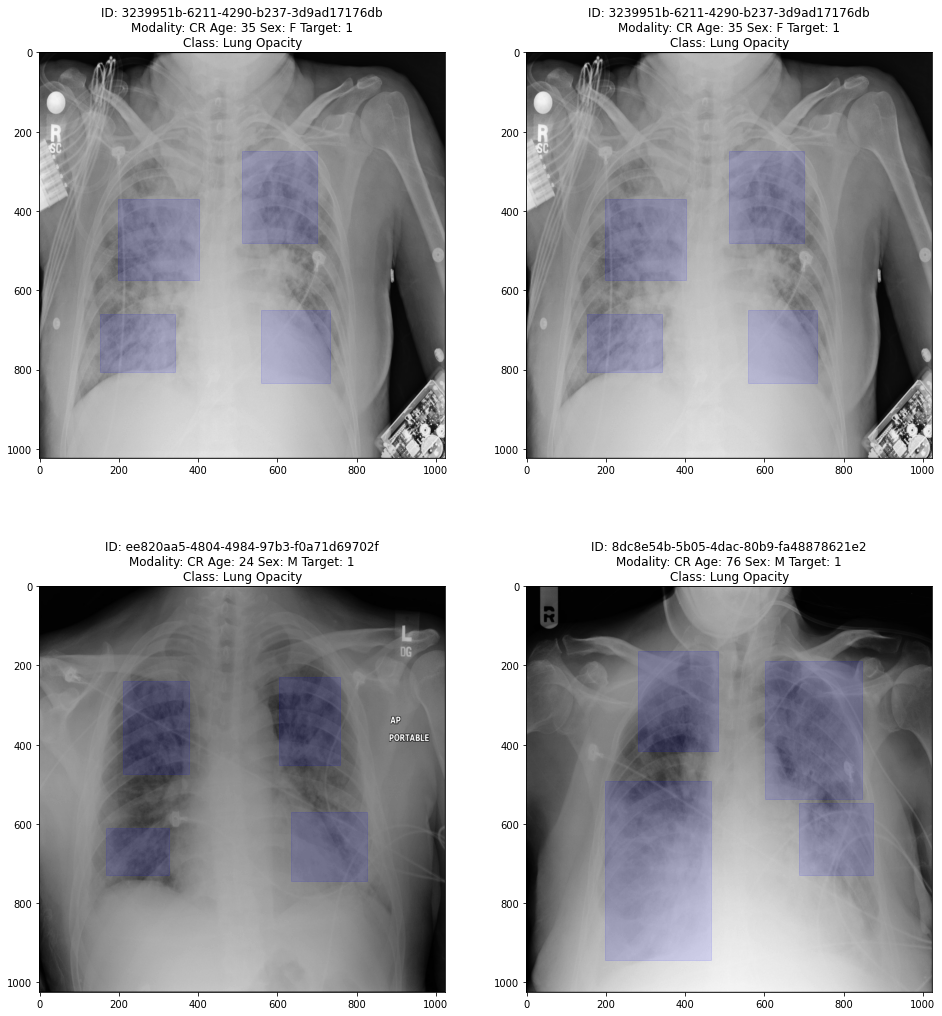

In [ ]:
data = train_labels[train_labels['number_of_bounding_boxes']==4].sample(4) 
boundbox(data)

**X-ray images with TARGET=1**

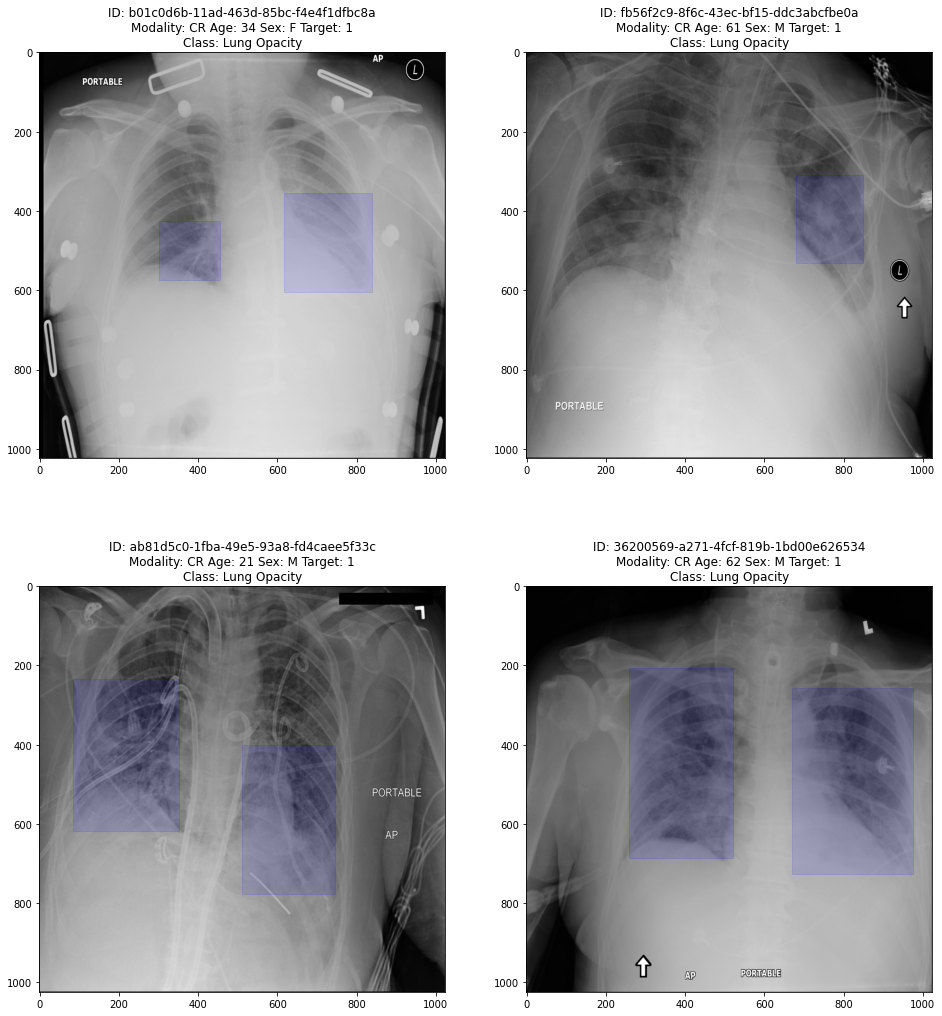

In [ ]:
data = training_data[training_data['Target']==1].sample(4) #target is 1
boundbox(data)

**X-ray images with TARGET=0 => no bounding box**

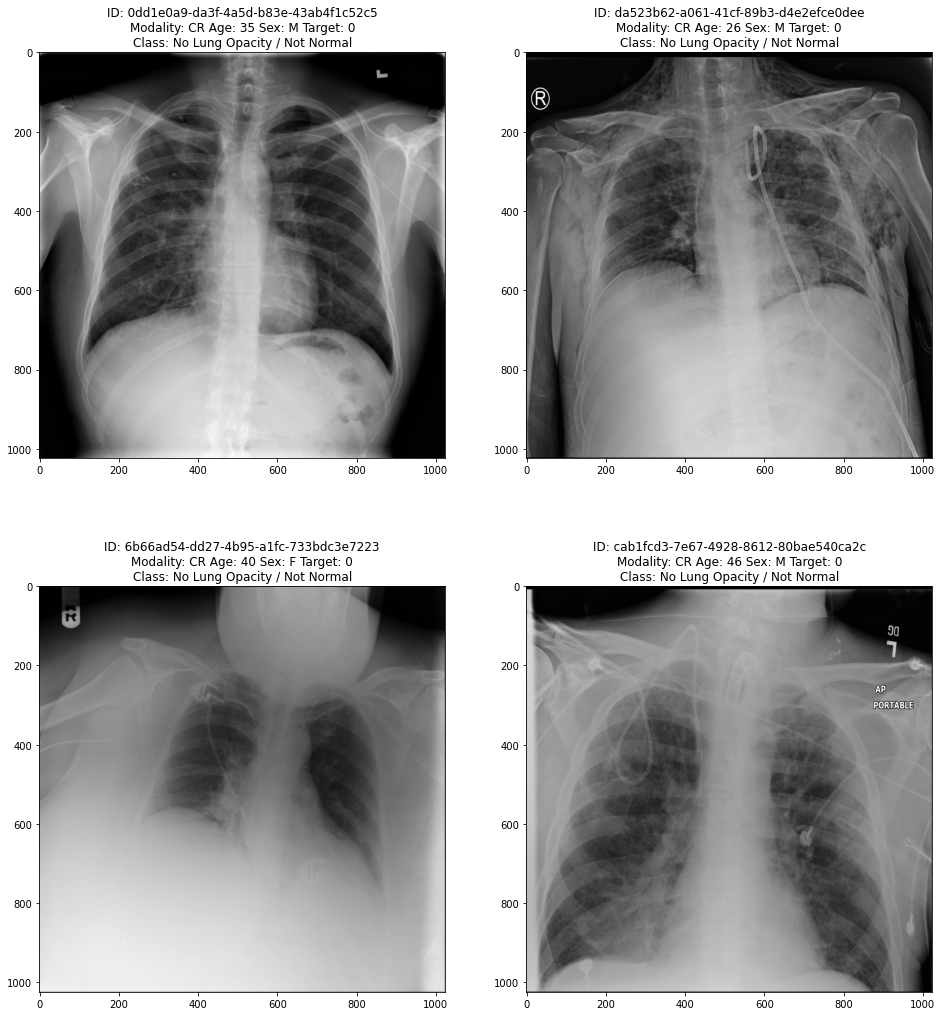

In [ ]:
data1 = training_data[training_data['Target']==0].sample(4) #target is 0
boundbox(data1)

**Step 6: Design, train and test basic CNN models for classification. [ 10 points]**

In [ ]:
training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class Modality  PatientAge PatientSex ViewPosition  \
0  No Lung Opacity / Not Normal       CR          51          F           PA   
1  No Lung Opacity / Not Normal       CR          48          F           PA   
2  No Lung Opacity / Not Normal       CR          19          M           AP   
3                        Normal       CR          28          M           PA   
4                  Lung Opacity       CR          32          F           AP   

                                                path  
0  drive/My Drive/cv capstone/stage_2_train_image...  
1  drive/My Drive/cv capstone/stage_2_train_image...  
2  drive/My Drive/cv capstone/stage_2_train_image...  
3  drive/My Drive/cv capstone/stage_2_train_image...  
4  drive/My Drive/cv capstone/stage_2_train_image...

In [ ]:
#model_trainigdata = training_data.groupby('Target', group_keys=False).apply(lambda x: x.sample(7000))
model_trainigdata = training_data

In [ ]:
model_trainigdata["Target"].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [6]:
NEW_IMAGE_SIZE = 128
EPOCH = 20
NUM_CLASSES = 1
NUM_CHANNELS = 3

In [ ]:
from tqdm import tqdm_notebook
def resizeImage(row):
  image_data_list = [];
  target_list = [];
  for index, row in tqdm_notebook(row.iterrows()):
    patientId = row.patientId
    target = row["Target"]
    dcm_file = 'drive/My Drive/cv capstone/stage_2_train_images/' + '{}.dcm'.format(patientId)
    image_data_array = dcm.read_file(dcm_file).pixel_array

    if len(image_data_array.shape) != 3 or image_data_array.shape[2] != 3:
      image_data_array = np.stack((image_data_array,) * 3, -1)

    image_array = np.array(image_data_array).astype(np.uint8)
    image_data_array = cv2.resize(image_array, (NEW_IMAGE_SIZE, NEW_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    image_data_list.append(image_data_array)
    target_list.append(target)
  return image_data_list, target_list


In [ ]:
  imageData, targets = resizeImage(model_trainigdata)
  imageData = np.array(imageData)
  targets = np.array(targets)

<ipython-input-16-0c5e939fc742>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm_notebook(row.iterrows()):


0it [00:00, ?it/s]

In [ ]:
#create a file
picklefile = open('drive/My Drive/cv capstone/xtrain2', 'wb')
picklefile1 = open('drive/My Drive/cv capstone/y2', 'wb')
#pickle the dataframe
pickle.dump(imageData, picklefile)
pickle.dump(targets, picklefile1)
#close file
picklefile.close()
picklefile1.close()

In [3]:
picklefile = open('drive/My Drive/cv capstone/xtrain2', 'rb')
picklefile1 = open('drive/My Drive/cv capstone/y2', 'rb')
#unpickle the dataframe
imgs= pickle.load(picklefile)
lbl= pickle.load(picklefile1)
#close file
picklefile.close()
picklefile1.close()
#print the dataframe
print(type(imgs))
print(type(lbl))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [4]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
encoded_targets = enc.fit_transform(lbl)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs, encoded_targets, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=50)

In [ ]:
def buildBasicModel(loss='binary_crossentropy', metrics=['accuracy']):
    shape_input = (128,128,3)
    model = Sequential()
    model.add(Conv2D(filters = 32,kernel_size=(5,5),input_shape=shape_input))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(NUM_CLASSES, activation = "sigmoid"))
    model.compile(loss=loss, metrics=metrics)
    model.summary()
    return model

In [ ]:
model = buildBasicModel()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 global_max_pooling2d_2 (Glo  (None, 32)               0         
 balMaxPooling2D)                                                
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size = 32)

Epoch 1/5
662/662 [==============================] - 19s 14ms/step - loss: 4.8446 - accuracy: 0.6142 - val_loss: 2.4039 - val_accuracy: 0.4763
Epoch 2/5
662/662 [==============================] - 9s 13ms/step - loss: 1.1455 - accuracy: 0.6291 - val_loss: 1.1273 - val_accuracy: 0.6944
Epoch 3/5
662/662 [==============================] - 9s 13ms/step - loss: 0.8318 - accuracy: 0.6543 - val_loss: 0.7861 - val_accuracy: 0.6853
Epoch 4/5
662/662 [==============================] - 8s 12ms/step - loss: 0.7590 - accuracy: 0.6679 - val_loss: 0.9675 - val_accuracy: 0.5980
Epoch 5/5
662/662 [==============================] - 8s 12ms/step - loss: 0.7264 - accuracy: 0.6712 - val_loss: 0.6522 - val_accuracy: 0.6950


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = 1)
print("Train loss:", loss)
print("Train_Accuracy:", accuracy)

662/662 [==============================] - 4s 6ms/step - loss: 0.6669 - accuracy: 0.6952
Train loss: 0.6669108867645264
Train_Accuracy: 0.6951507925987244


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = 1)
print("Test loss:", loss)
print("Test_Accuracy:", accuracy)

142/142 [==============================] - 1s 7ms/step - loss: 0.6785 - accuracy: 0.6861
Test loss: 0.6785261631011963
Test_Accuracy: 0.6861491203308105


In [ ]:
y_pred=(model.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred),'\n')

142/142 [==============================] - 1s 5ms/step
Confusion Matrix:
 [[2901  181]
 [1242  210]] 



In [ ]:
print('Classification Report:\n',classification_report(y_test,y_pred),'\n')

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.94      0.80      3082
           1       0.54      0.14      0.23      1452

    accuracy                           0.69      4534
   macro avg       0.62      0.54      0.52      4534
weighted avg       0.65      0.69      0.62      4534
 



In [ ]:
print('Accuracy Score:\n',accuracy_score(y_test,y_pred),'\n')

Accuracy Score:
 0.6861490957212175 



In [ ]:
eval=model.evaluate(X_test,y_test)
print('Model Evaluation Loss :\n',eval[0])
print('Model Evaluation Accuracy :\n',eval[1])

142/142 [==============================] - 1s 6ms/step - loss: 0.6785 - accuracy: 0.6861
Model Evaluation Loss :
 0.6785261631011963
Model Evaluation Accuracy :
 0.6861491203308105


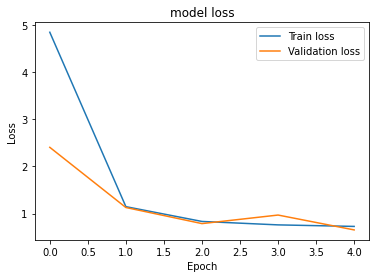

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='best')
plt.show()
#Validation loss is test loss

142/142 [==============================] - 1s 5ms/step


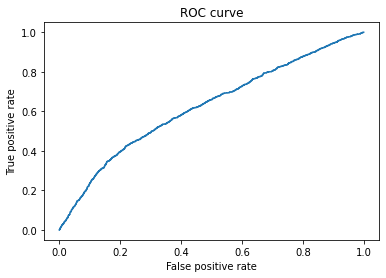

In [ ]:
from sklearn.metrics import roc_curve
#define metrics
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# Milestone 2

**Step 1: Fine tune the trained basic CNN models for classification. [ 5 points ]**

In [ ]:
def FineTunedCNNModel(loss='binary_crossentropy', metrics=['accuracy']):
    shape_input = (128,128,3)
    model = Sequential()
    model.add(Conv2D(filters = 32,kernel_size=(5,5), padding = 'Same', activation='relu',input_shape=shape_input))
    model.add(Conv2D(filters = 32,kernel_size=(5,5), padding = 'Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters = 64,kernel_size=(4,4), padding = 'Same', activation='relu'))
    model.add(Conv2D(filters = 64,kernel_size=(4,4), padding = 'Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters = 128,kernel_size=(3,3), padding = 'Same', activation='relu'))
    model.add(Conv2D(filters = 128,kernel_size=(3,3), padding = 'Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.4))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation = "sigmoid"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()
    return model


In [ ]:
model = FineTunedCNNModel()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        32832     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        65600     
                                                      

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val, y_val), batch_size = 32)

Epoch 1/20
662/662 [==============================] - 51s 71ms/step - loss: 0.7004 - accuracy: 0.6788 - val_loss: 0.6035 - val_accuracy: 0.6946
Epoch 2/20
662/662 [==============================] - 45s 67ms/step - loss: 0.5772 - accuracy: 0.6895 - val_loss: 0.5682 - val_accuracy: 0.6955
Epoch 3/20
662/662 [==============================] - 44s 66ms/step - loss: 0.5652 - accuracy: 0.6925 - val_loss: 0.6266 - val_accuracy: 0.7045
Epoch 4/20
662/662 [==============================] - 45s 69ms/step - loss: 0.5631 - accuracy: 0.6991 - val_loss: 0.5551 - val_accuracy: 0.7197
Epoch 5/20
662/662 [==============================] - 48s 73ms/step - loss: 0.5551 - accuracy: 0.6984 - val_loss: 0.5652 - val_accuracy: 0.7074
Epoch 6/20
662/662 [==============================] - 45s 67ms/step - loss: 0.5543 - accuracy: 0.6995 - val_loss: 0.5744 - val_accuracy: 0.7178
Epoch 7/20
662/662 [==============================] - 45s 67ms/step - loss: 0.5512 - accuracy: 0.7057 - val_loss: 0.5998 - val_accuracy:

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = 1)
print("Train loss:", loss)
print("Train_Accuracy:", accuracy)

662/662 [==============================] - 14s 21ms/step - loss: 0.4843 - accuracy: 0.7759
Train loss: 0.4843025207519531
Train_Accuracy: 0.775924026966095


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = 1)
print("Test loss:", loss)
print("Test_Accuracy:", accuracy)

In [ ]:
y_pred=(model.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred),'\n')

142/142 [==============================] - 3s 19ms/step
Confusion Matrix:
 [[2834  248]
 [ 847  605]] 



In [ ]:
print('Classification Report:\n',classification_report(y_test,y_pred),'\n')

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      3082
           1       0.71      0.42      0.52      1452

    accuracy                           0.76      4534
   macro avg       0.74      0.67      0.68      4534
weighted avg       0.75      0.76      0.74      4534
 



In [ ]:
print('Accuracy Score:\n',accuracy_score(y_test,y_pred),'\n')

Accuracy Score:
 0.7584913983237759 



In [ ]:
eval=model.evaluate(X_test,y_test)
print('Model Evaluation Loss :\n',eval[0])
print('Model Evaluation Accuracy :\n',eval[1])

142/142 [==============================] - 3s 22ms/step - loss: 0.5035 - accuracy: 0.7585
Model Evaluation Loss :
 0.5034609436988831
Model Evaluation Accuracy :
 0.7584913969039917


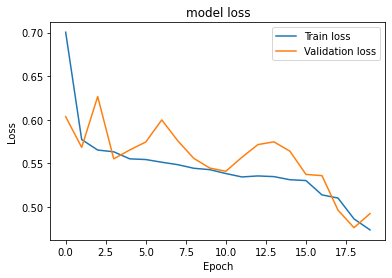

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='best')
plt.show()
#Validation loss is test loss

142/142 [==============================] - 3s 19ms/step


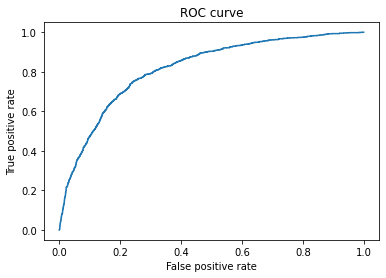

In [ ]:
from sklearn.metrics import roc_curve
#define metrics
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Step 2: Apply Transfer Learning model for classification [4 points]**

**DeneNet with Validation data**

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input,GlobalAveragePooling2D

def build_model():
    input_shape = (NEW_IMAGE_SIZE,NEW_IMAGE_SIZE,NUM_CHANNELS)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    denseNetModel = DenseNet121(include_top = False, input_tensor = inputs, weights ='imagenet')
    densenet = Model(inputs = inputs, outputs = denseNetModel.layers[-1].output, name = 'DenseNet121')
    model = Sequential(name = 'DenseNet121')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

In [8]:
model = build_model()

29084464/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DenseNet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [9]:
import tensorflow as tf
def cosine_annealing(x):
    lr = 0.001
    epochs = EPOCH
    return lr* (np.cos(np.pi*x/epochs)+1.) /2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=4, restore_best_weights=True, verbose=1, mode='auto')

In [10]:
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 1e-4
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']
model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
history=model.fit(X_train,y_train,
          validation_data=(X_val,y_val),
          callbacks=[learning_rate,early_stopping],
          epochs=EPOCH,
          batch_size=32)

Epoch 1/20
662/662 [==============================] - 119s 142ms/step - loss: 0.4607 - accuracy: 0.7891 - val_loss: 0.4316 - val_accuracy: 0.8121 - lr: 0.0010
Epoch 2/20
662/662 [==============================] - 88s 132ms/step - loss: 0.4165 - accuracy: 0.8098 - val_loss: 0.9443 - val_accuracy: 0.4192 - lr: 9.9384e-04
Epoch 3/20
662/662 [==============================] - 87s 132ms/step - loss: 0.4015 - accuracy: 0.8166 - val_loss: 0.4087 - val_accuracy: 0.8243 - lr: 9.7553e-04
Epoch 4/20
662/662 [==============================] - 87s 131ms/step - loss: 0.3979 - accuracy: 0.8182 - val_loss: 0.4356 - val_accuracy: 0.7890 - lr: 9.4550e-04
Epoch 5/20
662/662 [==============================] - 87s 131ms/step - loss: 0.3945 - accuracy: 0.8207 - val_loss: 0.4309 - val_accuracy: 0.7916 - lr: 9.0451e-04
Epoch 6/20
662/662 [==============================] - 90s 136ms/step - loss: 0.3769 - accuracy: 0.8267 - val_loss: 0.4237 - val_accuracy: 0.8119 - lr: 8.5355e-04
Epoch 7/20
662/662 [===========

In [ ]:
y_pred=(model.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred),'\n')

142/142 [==============================] - 7s 39ms/step
Confusion Matrix:
 [[2751  331]
 [ 581  871]] 



In [ ]:
print('Classification Report:\n',classification_report(y_test,y_pred),'\n')

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      3082
           1       0.72      0.60      0.66      1452

    accuracy                           0.80      4534
   macro avg       0.78      0.75      0.76      4534
weighted avg       0.79      0.80      0.79      4534
 



In [ ]:
print('Accuracy Score:\n',accuracy_score(y_test,y_pred),'\n')

Accuracy Score:
 0.7988531098367887 



In [ ]:
eval=model.evaluate(X_test,y_test,verbose=0)
print('Model Evaluation Loss :\n',eval[0])
print('Model Evaluation Accuracy :\n',eval[1])

Model Evaluation Loss :
 0.4331631064414978
Model Evaluation Accuracy :
 0.7988530993461609


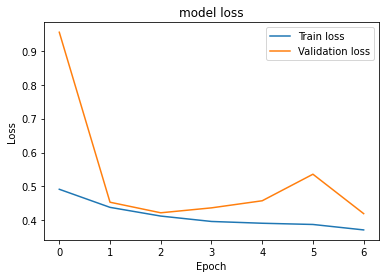

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='best')
plt.show()
#Validation loss is test loss

142/142 [==============================] - 7s 38ms/step


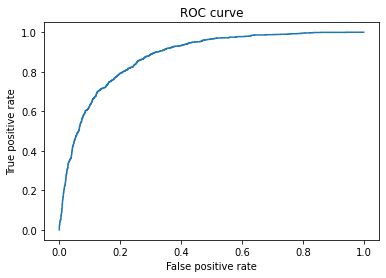

In [12]:
from sklearn.metrics import roc_curve
#define metrics
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

142/142 [==============================] - 5s 34ms/step
Actual label: [0]
Predicted label: [0]
Model output: [0.15260364]


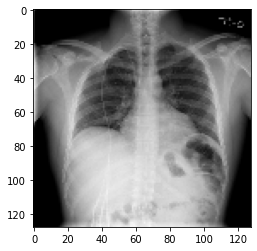

In [ ]:
plt.imshow(X_test[0], cmap ='gray')
y_pred = model.predict(X_test)
output=(model.predict(X_test) > 0.5).astype("int32")
print("Actual label:", y_test[0])
print("Predicted label:", output[0])
print("Model output:", y_pred[0])

**No validation data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(imgs, encoded_targets, test_size=0.2, random_state=50)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input,GlobalAveragePooling2D

def build_DenseNet_model_without_validation_data():
    input_shape = (NEW_IMAGE_SIZE,NEW_IMAGE_SIZE,NUM_CHANNELS)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    denseNetModel = DenseNet121(include_top = False, input_tensor = inputs, weights ='imagenet')
    densenet = Model(inputs = inputs, outputs = denseNetModel.layers[-1].output, name = 'DenseNet121')
    model = Sequential(name = 'DenseNet121')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

In [ ]:
model_densenet_without_validation_data=build_DenseNet_model_without_validation_data()

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DenseNet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 1e-4
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']
model_densenet_without_validation_data.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model_densenet_without_validation_data.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=EPOCH,
          batch_size=64)

Epoch 1/20
378/378 [==============================] - 119s 276ms/step - loss: 0.5183 - accuracy: 0.7661 - val_loss: 0.4274 - val_accuracy: 0.8205
Epoch 2/20
378/378 [==============================] - 98s 259ms/step - loss: 0.3768 - accuracy: 0.8314 - val_loss: 0.4450 - val_accuracy: 0.8329
Epoch 3/20
378/378 [==============================] - 99s 262ms/step - loss: 0.2981 - accuracy: 0.8656 - val_loss: 0.4005 - val_accuracy: 0.8334
Epoch 4/20
378/378 [==============================] - 98s 260ms/step - loss: 0.2207 - accuracy: 0.9073 - val_loss: 0.5492 - val_accuracy: 0.8133
Epoch 5/20
378/378 [==============================] - 98s 259ms/step - loss: 0.1520 - accuracy: 0.9385 - val_loss: 0.5553 - val_accuracy: 0.7810
Epoch 6/20
378/378 [==============================] - 98s 260ms/step - loss: 0.1129 - accuracy: 0.9562 - val_loss: 0.5555 - val_accuracy: 0.8407
Epoch 7/20
378/378 [==============================] - 98s 258ms/step - loss: 0.0862 - accuracy: 0.9668 - val_loss: 0.6486 - val_a

In [ ]:
ytrain_pred=(model_densenet_without_validation_data.predict(X_train) > 0.5).astype("int32")
print('Confusion Matrix of train :\n',confusion_matrix(y_train,ytrain_pred),'\n')

756/756 [==============================] - 27s 34ms/step
Confusion Matrix of train :
 [[16222   288]
 [  163  7508]] 



In [ ]:
y_pred=(model_densenet_without_validation_data.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix of test:\n',confusion_matrix(y_test,y_pred),'\n')

189/189 [==============================] - 6s 33ms/step
Confusion Matrix of test:
 [[3603  559]
 [ 397 1487]] 



In [ ]:
print('Classification Report of train:\n',classification_report(y_train,ytrain_pred),'\n')

Classification Report of train:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     16510
           1       0.96      0.98      0.97      7671

    accuracy                           0.98     24181
   macro avg       0.98      0.98      0.98     24181
weighted avg       0.98      0.98      0.98     24181
 



In [ ]:
print('Classification Report of test:\n',classification_report(y_test,y_pred),'\n')

Classification Report of test:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      4162
           1       0.73      0.79      0.76      1884

    accuracy                           0.84      6046
   macro avg       0.81      0.83      0.82      6046
weighted avg       0.85      0.84      0.84      6046
 



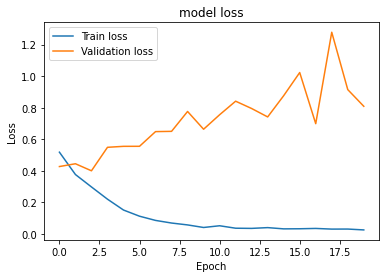

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='best')
plt.show()
#Validation loss is test loss

**VGG16**

In [13]:
IMAGE_SIZE = [128,128]
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = "imagenet", include_top = False)
for layer in vgg.layers:
  layer.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [14]:
x = Flatten()(vgg.output)
prediction = Dense(1, activation = "sigmoid")(x)
model_vgg16 = Model(inputs = vgg.input, outputs = prediction)
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [15]:
model_vgg16.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [16]:
history=model_vgg16.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=EPOCH,
          batch_size=32)

Epoch 1/20
662/662 [==============================] - 46s 66ms/step - loss: 2.0466 - accuracy: 0.7402 - val_loss: 1.7433 - val_accuracy: 0.7464
Epoch 2/20
662/662 [==============================] - 41s 62ms/step - loss: 1.4393 - accuracy: 0.7842 - val_loss: 3.2472 - val_accuracy: 0.7177
Epoch 3/20
662/662 [==============================] - 41s 62ms/step - loss: 1.3828 - accuracy: 0.7955 - val_loss: 1.9163 - val_accuracy: 0.7475
Epoch 4/20
662/662 [==============================] - 41s 62ms/step - loss: 1.3962 - accuracy: 0.8082 - val_loss: 1.8397 - val_accuracy: 0.7689
Epoch 5/20
662/662 [==============================] - 41s 62ms/step - loss: 1.1183 - accuracy: 0.8240 - val_loss: 2.0396 - val_accuracy: 0.7552
Epoch 6/20
662/662 [==============================] - 41s 61ms/step - loss: 1.1514 - accuracy: 0.8278 - val_loss: 2.5209 - val_accuracy: 0.7682
Epoch 7/20
662/662 [==============================] - 44s 66ms/step - loss: 1.0045 - accuracy: 0.8404 - val_loss: 2.3588 - val_accuracy:

In [ ]:
ytrain_pred=(model_vgg16.predict(X_train) > 0.5).astype("int32")
print('Confusion Matrix of train :\n',confusion_matrix(y_train,ytrain_pred),'\n')

756/756 [==============================] - 38s 50ms/step
Confusion Matrix of train :
 [[13207  3303]
 [  389  7282]] 



In [ ]:
y_pred=(model_vgg16.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix of test:\n',confusion_matrix(y_test,y_pred),'\n')

189/189 [==============================] - 9s 50ms/step
Confusion Matrix of test:
 [[2996 1166]
 [ 349 1535]] 



In [ ]:
print('Classification Report of train:\n',classification_report(y_train,ytrain_pred),'\n')

Classification Report of train:
               precision    recall  f1-score   support

           0       0.97      0.80      0.88     16510
           1       0.69      0.95      0.80      7671

    accuracy                           0.85     24181
   macro avg       0.83      0.87      0.84     24181
weighted avg       0.88      0.85      0.85     24181
 



In [ ]:
print('Classification Report of test:\n',classification_report(y_test,y_pred),'\n')

Classification Report of test:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      4162
           1       0.57      0.81      0.67      1884

    accuracy                           0.75      6046
   macro avg       0.73      0.77      0.73      6046
weighted avg       0.79      0.75      0.76      6046
 



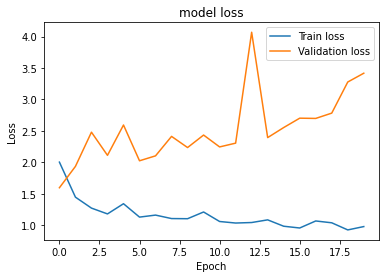

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='best')
plt.show()
#Validation loss is test loss

142/142 [==============================] - 7s 48ms/step


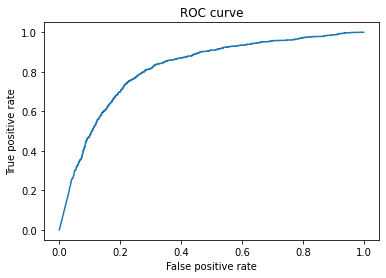

In [17]:
from sklearn.metrics import roc_curve
#define metrics
y_pred_keras = model_vgg16.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**VGG19**

In [3]:
IMAGE_SIZE = [128,128]
vgg = VGG19(input_shape = IMAGE_SIZE + [3], weights = "imagenet", include_top = False)
for layer in vgg.layers:
  layer.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [4]:
x = Flatten()(vgg.output)
prediction = Dense(1, activation = "sigmoid")(x)
model_vgg19 = Model(inputs = vgg.input, outputs = prediction)
model_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [5]:
model_vgg19.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [18]:
history=model_vgg19.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=EPOCH,
          batch_size=32)

Epoch 1/20
662/662 [==============================] - 51s 76ms/step - loss: 2.0919 - accuracy: 0.7346 - val_loss: 1.7447 - val_accuracy: 0.7810
Epoch 2/20
662/662 [==============================] - 50s 75ms/step - loss: 1.4544 - accuracy: 0.7767 - val_loss: 1.8662 - val_accuracy: 0.7166
Epoch 3/20
662/662 [==============================] - 49s 73ms/step - loss: 1.2693 - accuracy: 0.7975 - val_loss: 1.7167 - val_accuracy: 0.7644
Epoch 4/20
662/662 [==============================] - 48s 73ms/step - loss: 1.2129 - accuracy: 0.8087 - val_loss: 2.0738 - val_accuracy: 0.7607
Epoch 5/20
662/662 [==============================] - 48s 73ms/step - loss: 1.3124 - accuracy: 0.8109 - val_loss: 2.0432 - val_accuracy: 0.7744
Epoch 6/20
662/662 [==============================] - 48s 73ms/step - loss: 1.2294 - accuracy: 0.8230 - val_loss: 2.1400 - val_accuracy: 0.7728
Epoch 7/20
662/662 [==============================] - 48s 73ms/step - loss: 1.1301 - accuracy: 0.8308 - val_loss: 2.1088 - val_accuracy:

In [ ]:
ytrain_pred=(model_vgg19.predict(X_train) > 0.5).astype("int32")
print('Confusion Matrix of train :\n',confusion_matrix(y_train,ytrain_pred),'\n')

756/756 [==============================] - 45s 59ms/step
Confusion Matrix of train :
 [[15860   650]
 [ 2390  5281]] 



In [ ]:
y_pred=(model_vgg19.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix of test:\n',confusion_matrix(y_test,y_pred),'\n')

189/189 [==============================] - 11s 57ms/step
Confusion Matrix of test:
 [[3593  569]
 [ 865 1019]] 



In [ ]:
print('Classification Report of train:\n',classification_report(y_train,ytrain_pred),'\n')

Classification Report of train:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     16510
           1       0.89      0.69      0.78      7671

    accuracy                           0.87     24181
   macro avg       0.88      0.82      0.84     24181
weighted avg       0.88      0.87      0.87     24181
 



In [ ]:
print('Classification Report of test:\n',classification_report(y_test,y_pred),'\n')

Classification Report of test:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      4162
           1       0.64      0.54      0.59      1884

    accuracy                           0.76      6046
   macro avg       0.72      0.70      0.71      6046
weighted avg       0.75      0.76      0.76      6046
 



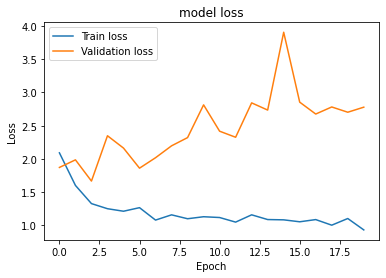

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='best')
plt.show()
#Validation loss is test loss

142/142 [==============================] - 9s 60ms/step


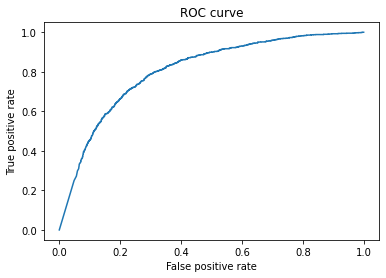

In [21]:
from sklearn.metrics import roc_curve
#define metrics
y_pred_keras = model_vgg19.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**RESNET**

In [13]:
IMAGE_SIZE = [128,128]
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights = "imagenet", include_top = False)
for layer in resnet.layers:
  layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [14]:
x = Flatten()(resnet.output)
prediction = Dense(1, activation = "sigmoid")(x)
model_resnet = Model(inputs = resnet.input, outputs = prediction)
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [15]:
model_resnet.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [19]:
history=model_resnet.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=EPOCH,
          batch_size=32)

Epoch 1/20
662/662 [==============================] - 35s 48ms/step - loss: 1.0551 - accuracy: 0.7523 - val_loss: 0.9840 - val_accuracy: 0.7611
Epoch 2/20
662/662 [==============================] - 30s 45ms/step - loss: 0.6879 - accuracy: 0.8182 - val_loss: 0.9882 - val_accuracy: 0.7750
Epoch 3/20
662/662 [==============================] - 30s 45ms/step - loss: 0.5167 - accuracy: 0.8547 - val_loss: 1.3641 - val_accuracy: 0.7558
Epoch 4/20
662/662 [==============================] - 30s 46ms/step - loss: 0.3814 - accuracy: 0.8860 - val_loss: 1.0551 - val_accuracy: 0.7746
Epoch 5/20
662/662 [==============================] - 30s 45ms/step - loss: 0.3390 - accuracy: 0.8981 - val_loss: 1.1372 - val_accuracy: 0.7812
Epoch 6/20
662/662 [==============================] - 30s 45ms/step - loss: 0.2922 - accuracy: 0.9142 - val_loss: 1.1592 - val_accuracy: 0.8068
Epoch 7/20
662/662 [==============================] - 30s 45ms/step - loss: 0.3072 - accuracy: 0.9163 - val_loss: 1.2740 - val_accuracy:

In [ ]:
ytrain_pred=(model_resnet.predict(X_train) > 0.5).astype("int32")
print('Confusion Matrix of train :\n',confusion_matrix(y_train,ytrain_pred),'\n')

756/756 [==============================] - 28s 37ms/step
Confusion Matrix of train :
 [[16510     0]
 [ 1457  6214]] 



In [ ]:
y_pred=(model_resnet.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix of test:\n',confusion_matrix(y_test,y_pred),'\n')

189/189 [==============================] - 7s 37ms/step
Confusion Matrix of test:
 [[3886  276]
 [ 829 1055]] 



In [ ]:
print('Classification Report of train:\n',classification_report(y_train,ytrain_pred),'\n')

Classification Report of train:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     16510
           1       1.00      0.81      0.90      7671

    accuracy                           0.94     24181
   macro avg       0.96      0.91      0.93     24181
weighted avg       0.94      0.94      0.94     24181
 



In [ ]:
print('Classification Report of test:\n',classification_report(y_test,y_pred),'\n')

Classification Report of test:
               precision    recall  f1-score   support

           0       0.82      0.93      0.88      4162
           1       0.79      0.56      0.66      1884

    accuracy                           0.82      6046
   macro avg       0.81      0.75      0.77      6046
weighted avg       0.81      0.82      0.81      6046
 



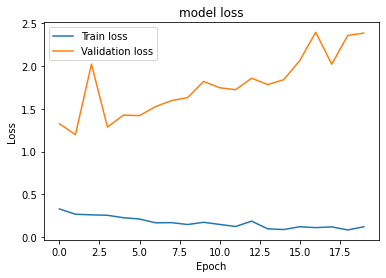

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='best')
plt.show()
#Validation loss is test loss

142/142 [==============================] - 6s 35ms/step


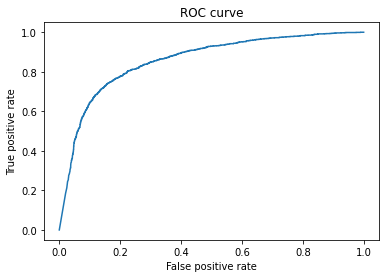

In [20]:
from sklearn.metrics import roc_curve
#define metrics
y_pred_keras = model_resnet.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**InceptionNet**

In [7]:
IMAGE_SIZE = [128,128]
inceptionNet = tf.keras.applications.InceptionV3(input_shape = IMAGE_SIZE + [3], weights = "imagenet", include_top = False)
for layer in inceptionNet.layers:
  layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [8]:
x = Flatten()(inceptionNet.output)
prediction = Dense(1, activation = "sigmoid")(x)
model_inceptionNet = Model(inputs = inceptionNet.input, outputs = prediction)
model_inceptionNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [9]:
model_inceptionNet.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [11]:
history=model_inceptionNet.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=5,
          batch_size=32)

Epoch 1/5
662/662 [==============================] - 28s 36ms/step - loss: 7.0997 - accuracy: 0.7068 - val_loss: 5.2263 - val_accuracy: 0.7667
Epoch 2/5
662/662 [==============================] - 22s 33ms/step - loss: 6.0465 - accuracy: 0.7160 - val_loss: 5.9041 - val_accuracy: 0.7585
Epoch 3/5
662/662 [==============================] - 22s 33ms/step - loss: 5.4998 - accuracy: 0.7294 - val_loss: 6.3901 - val_accuracy: 0.7135
Epoch 4/5
662/662 [==============================] - 22s 33ms/step - loss: 5.8539 - accuracy: 0.7309 - val_loss: 6.1762 - val_accuracy: 0.7640
Epoch 5/5
662/662 [==============================] - 22s 33ms/step - loss: 5.6806 - accuracy: 0.7332 - val_loss: 6.0937 - val_accuracy: 0.7750


In [ ]:
ytrain_pred=(model_inceptionNet.predict(X_train) > 0.5).astype("int32")
print('Confusion Matrix of train :\n',confusion_matrix(y_train,ytrain_pred),'\n')

756/756 [==============================] - 657s 867ms/step
Confusion Matrix of train :
 [[14560  1950]
 [ 2216  5455]] 



In [ ]:
y_pred=(model_inceptionNet.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix of test:\n',confusion_matrix(y_test,y_pred),'\n')

189/189 [==============================] - 168s 884ms/step
Confusion Matrix of test:
 [[3389  773]
 [ 528 1356]] 



In [ ]:
print('Classification Report of train:\n',classification_report(y_train,ytrain_pred),'\n')

Classification Report of train:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87     16510
           1       0.74      0.71      0.72      7671

    accuracy                           0.83     24181
   macro avg       0.80      0.80      0.80     24181
weighted avg       0.83      0.83      0.83     24181
 



In [ ]:
print('Classification Report of test:\n',classification_report(y_test,y_pred),'\n')

Classification Report of test:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      4162
           1       0.64      0.72      0.68      1884

    accuracy                           0.78      6046
   macro avg       0.75      0.77      0.76      6046
weighted avg       0.79      0.78      0.79      6046
 



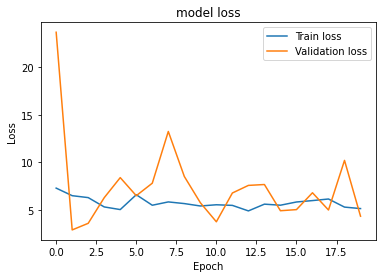

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='best')
plt.show()
#Validation loss is test loss

142/142 [==============================] - 3s 24ms/step


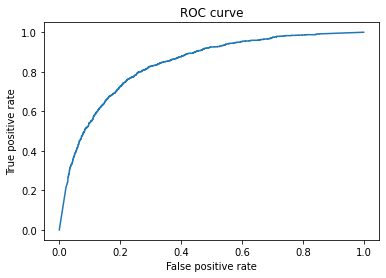

In [12]:
from sklearn.metrics import roc_curve
#define metrics
y_pred_keras = model_inceptionNet.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

**Step 3: Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or 
mask over the area of interest. [ 8 points ]**

In [ ]:
!unzip /content/drive/MyDrive/stage_2_train_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/f868de0f-be9e-4da2-aee7-b0bc5b66e086.dcm  
  inflating: __MACOSX/stage_2_train_images/._f868de0f-be9e-4da2-aee7-b0bc5b66e086.dcm  
  inflating: stage_2_train_images/bfdbe64f-1ab9-4b72-a4b5-3ef6a057add2.dcm  
  inflating: __MACOSX/stage_2_train_images/._bfdbe64f-1ab9-4b72-a4b5-3ef6a057add2.dcm  
  inflating: stage_2_train_images/4dbc44ca-694a-4814-9a24-bc60c8d8d611.dcm  
  inflating: __MACOSX/stage_2_train_images/._4dbc44ca-694a-4814-9a24-bc60c8d8d611.dcm  
  inflating: stage_2_train_images/eb056e61-98f0-418d-a5e9-b82bd8d2db93.dcm  
  inflating: __MACOSX/stage_2_train_images/._eb056e61-98f0-418d-a5e9-b82bd8d2db93.dcm  
  inflating: stage_2_train_images/379ee9d4-4c6f-41ca-a9ec-9c07bc721f7d.dcm  
  inflating: __MACOSX/stage_2_train_images/._379ee9d4-4c6f-41ca-a9ec-9c07bc721f7d.dcm  
  inflating: stage_2_train_images/eec65a2f-9b12-4884-b7b5-3707751332b9.dcm  
  inflating: __MACOSX/stage_2_train_images/._ee

In [ ]:
!unzip /content/drive/MyDrive/stage_2_test_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_test_images/2836c671-b555-4af7-b1c2-25d73cb113f1.dcm  
  inflating: __MACOSX/stage_2_test_images/._2836c671-b555-4af7-b1c2-25d73cb113f1.dcm  
  inflating: stage_2_test_images/1e2c8423-ba80-47dc-b590-841c472cbc27.dcm  
  inflating: __MACOSX/stage_2_test_images/._1e2c8423-ba80-47dc-b590-841c472cbc27.dcm  
  inflating: stage_2_test_images/1eda3687-bdf5-469f-8fba-5000c559f48b.dcm  
  inflating: __MACOSX/stage_2_test_images/._1eda3687-bdf5-469f-8fba-5000c559f48b.dcm  
  inflating: stage_2_test_images/243be28d-f021-457f-b86c-95394c9be74c.dcm  
  inflating: __MACOSX/stage_2_test_images/._243be28d-f021-457f-b86c-95394c9be74c.dcm  
  inflating: stage_2_test_images/2cdd3a1a-75d5-45bb-b8b4-0568cadd3f2b.dcm  
  inflating: __MACOSX/stage_2_test_images/._2cdd3a1a-75d5-45bb-b8b4-0568cadd3f2b.dcm  
  inflating: stage_2_test_images/00edcd2d-d727-486d-b15a-675855e4dca3.dcm  
  inflating: __MACOSX/stage_2_test_images/._00edcd2d-d727-

In [ ]:
filenames = {}
filenames = os.listdir('/content/stage_2_train_images')
file_count = len(filenames)
random.shuffle(filenames)

validation_data_len = int(file_count * 0.3)

train_data_filenames = filenames[validation_data_len:file_count]
validation_data_filenames = filenames[:validation_data_len]
print('n train samples', len(train_data_filenames))
print('n valid samples', len(validation_data_filenames))
train_data_len = file_count - validation_data_len

image_dimension = 128
print('Image Dimension to use:',image_dimension)
print('sample file:',filenames[0])

n train samples 18679
n valid samples 8005
Image Dimension to use: 128
sample file: fd5d1c97-9947-4703-bb8c-b5e5daeac9fe.dcm


In [ ]:
pneumonia_location_coordinates = {}
with open('drive/My Drive/cv capstone/stage_2_train_labels.csv') as infile:
    reader = csv.reader(infile)
    next(reader, None)
    for rows in reader:
        filename = rows[0]
        coordinates = rows[1:5]
        pneumonia = rows[5]
        if pneumonia == '1':
            coordinates = [int(float(i)) for i in coordinates]
            if filename in pneumonia_location_coordinates:
                pneumonia_location_coordinates[filename].append(coordinates)
            else:
                pneumonia_location_coordinates[filename] = [coordinates]

In [ ]:
def add_downsample_layer(num_of_channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(num_of_channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def add_residual_layer(num_of_channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(num_of_channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(num_of_channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

In [ ]:
import keras
def create_network(input_size, num_of_channels, num_of_blocks, depth):
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(num_of_channels, 3, padding='same', use_bias=False)(inputs)
    for d in range(depth):
        num_of_channels = num_of_channels * 2
        x = add_downsample_layer(num_of_channels, x)
        for b in range(num_of_blocks):
            x = add_residual_layer(num_of_channels, x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def iou_bce_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    jaccard_loss =  1 - score
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * jaccard_loss

def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

model = create_network(input_size=image_dimension, num_of_channels=32, num_of_blocks=2, depth=4)
model.compile(optimizer='adam',loss=iou_bce_loss,metrics=['accuracy', mean_iou])

model.summary()

def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr* (np.cos(np.pi*x/epochs)+1.) /2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
import keras
!pip install pydicom
import pydicom
class generator(keras.utils.Sequence):
    def __init__(self, folder, filenames, pneumonia_location_coordinates=None, batch_size=32, image_size=image_dimension, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_location_coordinates = pneumonia_location_coordinates
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
         
    def __load__(self, filename):
        img_array = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array
        msk = np.zeros(img_array.shape)
        filename = filename.split('.')[0]
        if filename in self.pneumonia_location_coordinates:
            for location in self.pneumonia_location_coordinates[filename]:
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        img_array = resize(img_array, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') 
        if self.augment and random.random() > 0.5:
            img_array = np.fliplr(img_array)
            msk = np.fliplr(msk)
        img_array = np.expand_dims(img_array, -1)
        msk = np.expand_dims(msk, -1)
        return img_array, msk
    
    def __loadpredict__(self, filename):
        img_array = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array
        img_array = resize(img_array, (self.image_size, self.image_size), mode='reflect')
        img_array = np.expand_dims(img_array, -1)
        return img_array

    def __getitem__(self, index):
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.predict:
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            imgs = np.array(imgs)
            return imgs, filenames
        else:
            items = [self.__load__(filename) for filename in filenames]
            imgs, msks = zip(*items)
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
  
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            return int(len(self.filenames) / self.batch_size)
        

train_gen = generator('/content/stage_2_train_images/', train_data_filenames, pneumonia_location_coordinates, batch_size=32, image_size=image_dimension, shuffle=True, augment=True, predict=False)
valid_gen = generator('/content/stage_2_train_images/', validation_data_filenames, pneumonia_location_coordinates, batch_size=32, image_size=image_dimension, shuffle=False, predict=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=4, restore_best_weights=True, verbose=1, mode='auto')

history = model.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate, early_stopping], epochs=5, workers=4, use_multiprocessing=True)

Epoch 1/5
583/583 [==============================] - 2928s 5s/step - loss: 0.4863 - accuracy: 0.9548 - mean_iou: 0.6715 - val_loss: 0.4576 - val_accuracy: 0.9584 - val_mean_iou: 0.7056 - lr: 0.0010
Epoch 2/5
583/583 [==============================] - 2918s 5s/step - loss: 0.4544 - accuracy: 0.9594 - mean_iou: 0.7064 - val_loss: 0.4637 - val_accuracy: 0.9502 - val_mean_iou: 0.6483 - lr: 9.9606e-04
Epoch 3/5
583/583 [==============================] - 2930s 5s/step - loss: 0.4457 - accuracy: 0.9605 - mean_iou: 0.7163 - val_loss: 0.4506 - val_accuracy: 0.9541 - val_mean_iou: 0.6608 - lr: 9.8429e-04
Epoch 4/5
583/583 [==============================] - 2938s 5s/step - loss: 0.4360 - accuracy: 0.9617 - mean_iou: 0.7229 - val_loss: 0.4526 - val_accuracy: 0.9541 - val_mean_iou: 0.6564 - lr: 9.6489e-04
Epoch 5/5
583/583 [==============================] - 2947s 5s/step - loss: 0.4318 - accuracy: 0.9621 - mean_iou: 0.7281 - val_loss: 0.4333 - val_accuracy: 0.9604 - val_mean_iou: 0.7301 - lr: 9.381

In [ ]:
# convert the model to a JSON string
model_json = model.to_json()

# save the JSON string to a file
with open("/content/drive/MyDrive/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/model.h5")   

In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('/content/drive/MyDrive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/model.h5")

**Step 4: Pickle the model for future prediction [ 3 Points]**

In [ ]:
picklefile = open('drive/My Drive/cv capstone/final_object_detection', 'wb')
pickle.dump(model, picklefile)
picklefile.close()

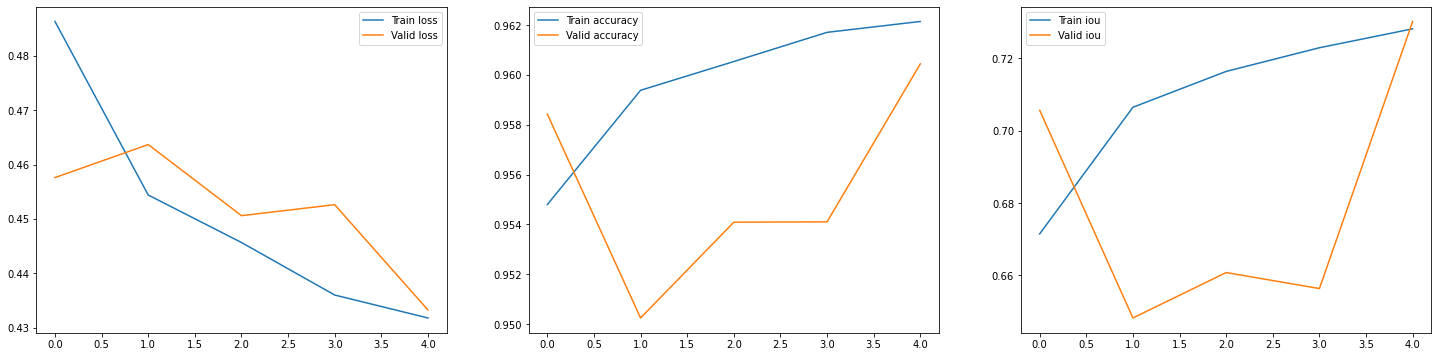

In [ ]:
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

1/1 [==============================] - 0s 369ms/step


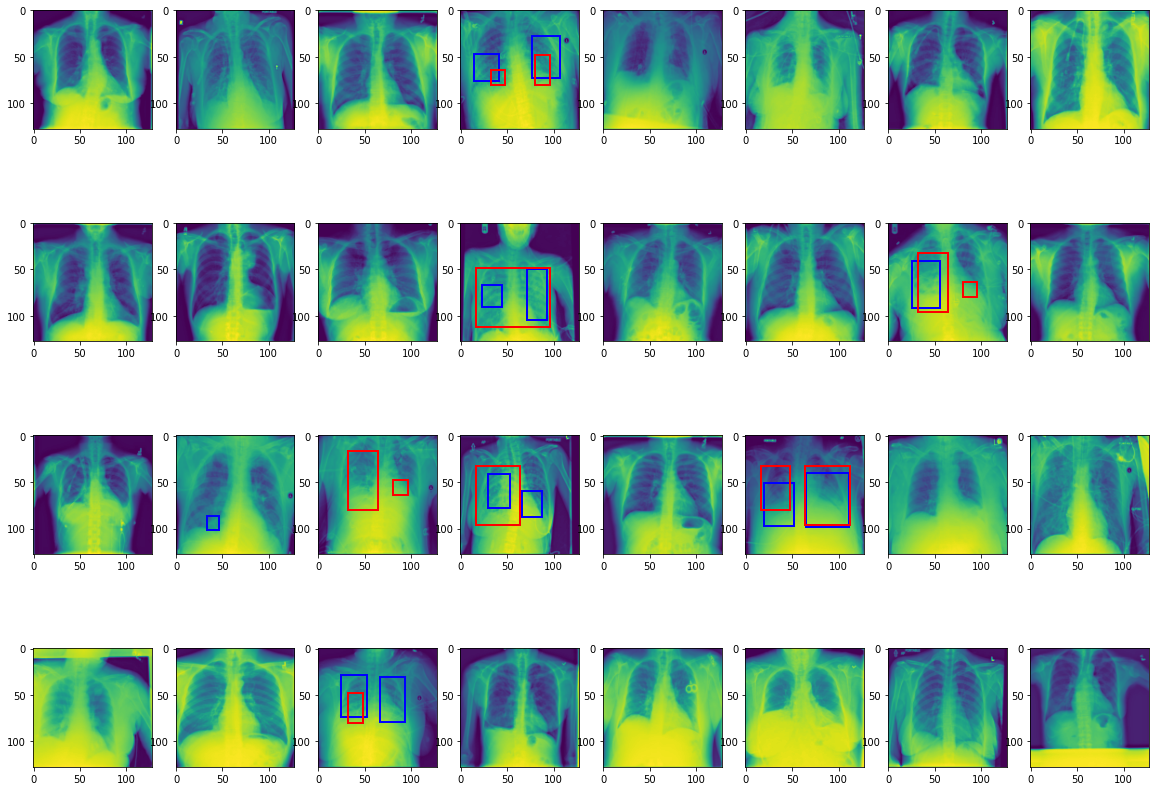

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Red is predicted mask, Blue is actual Mask
for images, masks in valid_gen:
    predictions = model.predict(images)
    fig, axarr = plt.subplots(4, 8, figsize=(20,15))
    axidx = 0
    axarr = axarr.ravel()

    for image, mask, pred in zip(images, masks, predictions):
        axarr[axidx].imshow(image[:, :, 0])
        component = mask[:, :, 0] > 0.5
        component = measure.label(component)
        for region in measure.regionprops(component):
            y1, x1, y2, x2 = region.bbox
            height = y2 - y1
            width = x2 - x1
            axarr[axidx].add_patch(patches.Rectangle((x1,y1),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        
        component = pred[:, :, 0] > 0.5
        component = measure.label(component)
        for region in measure.regionprops(component):
            y1, x1, y2, x2 = region.bbox
            height = y2 - y1
            width = x2 - x1
            axarr[axidx].add_patch(patches.Rectangle((x1,y1),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    break

In [ ]:
# load and shuffle filenames
folder = '/content/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=128, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('/content/drive/MyDrive/submission.csv')

n test samples: 3000
1/1 [==============================] - 0s 26ms/step


**There was a considerable IOU for the images where prediction was correct.**

In [ ]:
subm=pd.read_csv("/content/drive/MyDrive/submission.csv")

In [ ]:
subm.sample(10)

patientId  \
2680  116dd2ea-16d5-4765-b800-cb77b72dbcf5   
872   22d4c0ce-db48-4a4d-9653-a9e362c1f812   
324   1d832224-bbc0-46f7-af50-27546292dcd7   
218   1ad5385c-07a9-4f5d-aaad-83774ec96692   
2087  148243ba-ad33-454e-b7e9-a63f66affc8c   
1081  2c75136a-992f-477a-8a51-ee23fed87917   
270   1dd44ba2-d479-4f24-a7b0-e1e934aaea65   
1770  009ac78b-6b5c-45ef-b73b-855116887af4   
1889  02bc74a8-2ea2-4d73-a7b4-d2ae9c1ddfd7   
1557  136feda3-a969-4a76-ac47-9e72a43a1af7   

                                       PredictionString  
2680                                                NaN  
872                                                 NaN  
324                                                 NaN  
218                                                 NaN  
2087  0.8770801 637 381 259 514 0.8279368 128 383 38...  
1081                                                NaN  
270   0.9145001 256 383 256 385 0.5633788 643 387 12...  
1770                                                NaN  
1889                                                NaN  
1557                                                NaN

Thus based on our evaluation metric, the scores of the models we tried are as below for Target = 1 on test data:

| Model | Precision% | Recall% | F1-Score% | Accuracy% |
| --- | --- | --- | --- | -- |
| Basic CNN model | 62 | 54 | 52 | 69 |
| Fine tuned Basic CNN model | 56 | 60 | 58 | 72 |
| DenseNet with Validation data | 72 | 60 | 66 | 80 |
| **DenseNet** | **73** | **79** | **76** | **84** |
| VggNet16 |  57  | 81 | 67 | 75 |
| VggNet19 | 64 | 54 | 59 | 76 |
| ResNet | 79 | 56 |66 | 82 |
| InceptionNet | 64 | 72  |68 | 78 |

DenseNet with Adam optimizer trained for 20 epochs with data split as train and test in ratio 70:30 showed better result than all other models.

Boundin box Prediction model has validation accuracy of 96% and validation iou of 73%.
